## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.6 (heads/v0.3.5:42b268d, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 23.7 s, sys: 5min 16s, total: 5min 40s
Wall time: 33.9 s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with AMY1A region sequences 

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

AMY1A itself is small (~9kb). However, it resides in a region that have big repeats and the repeat configuration determines the copy numbers of AMY1A. In this analysis, we use 200k franking sequence on both ends to feteh the whole region.

68


(0.0, 409033.0)

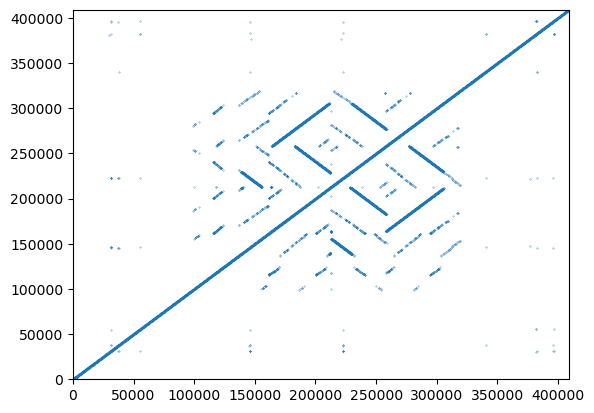

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr1_hg19', 104198140, 104207173
padding = 200000
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)

gene_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b, roi_e)

x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 125
The total aligned regions is 129


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG02080#1#JAHEOW010000048.1', 'HG02080.paternal.f1_assembly_v2_genbank.fa', 19194867) target region 16689583 - 17097287 len: 407704
('HG00621#2#JAHBCC010000031.1', 'HG00621.maternal.f1_assembly_v2_genbank.fa', 50348198) target region 16669999 - 17077865 len: 407866
('HG00621#1#JAHBCD010000034.1', 'HG00621.paternal.f1_assembly_v2_genbank.fa', 54097957) target region 2122997 - 2624098 len: 501101
('HG00733#1#JAHEPQ010000485.1', 'HG00733.paternal.f1_assembly_v2_genbank.fa', 282396) target region 246 - 281925 len: 281679
('HG01952#2#JAHAMD010000045.1', 'HG01952.maternal.f1_assembly_v2_genbank.fa', 21548543) target region 4381722 - 4883708 len: 501986
('NA21309#1#JAHEPC010000405.1', 'NA21309.paternal.f1_assembly_v2_genbank.fa', 49284) target region 258 - 47997 len: 47739
('HG01361#2#JAGYYW010000143.1', 'HG01361.maternal.f1_assembly_v2_genbank.fa', 119880) target region 674 - 119403 len: 118729
('HG01358#2#JAGYZA010000083.1', 'HG01358.maternal.f1_assembly_v2_genbank.fa', 51683152) target r

Text(0, 0.5, 'count')

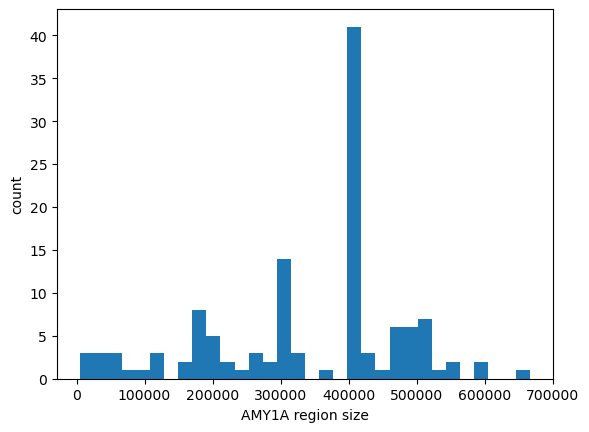

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("AMY1A region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the AMY1A by two vertical grey lines. We observe that there are different number of intersections (~different copy number of AMY1A) of the region the "dots" due to the different repeat structures.

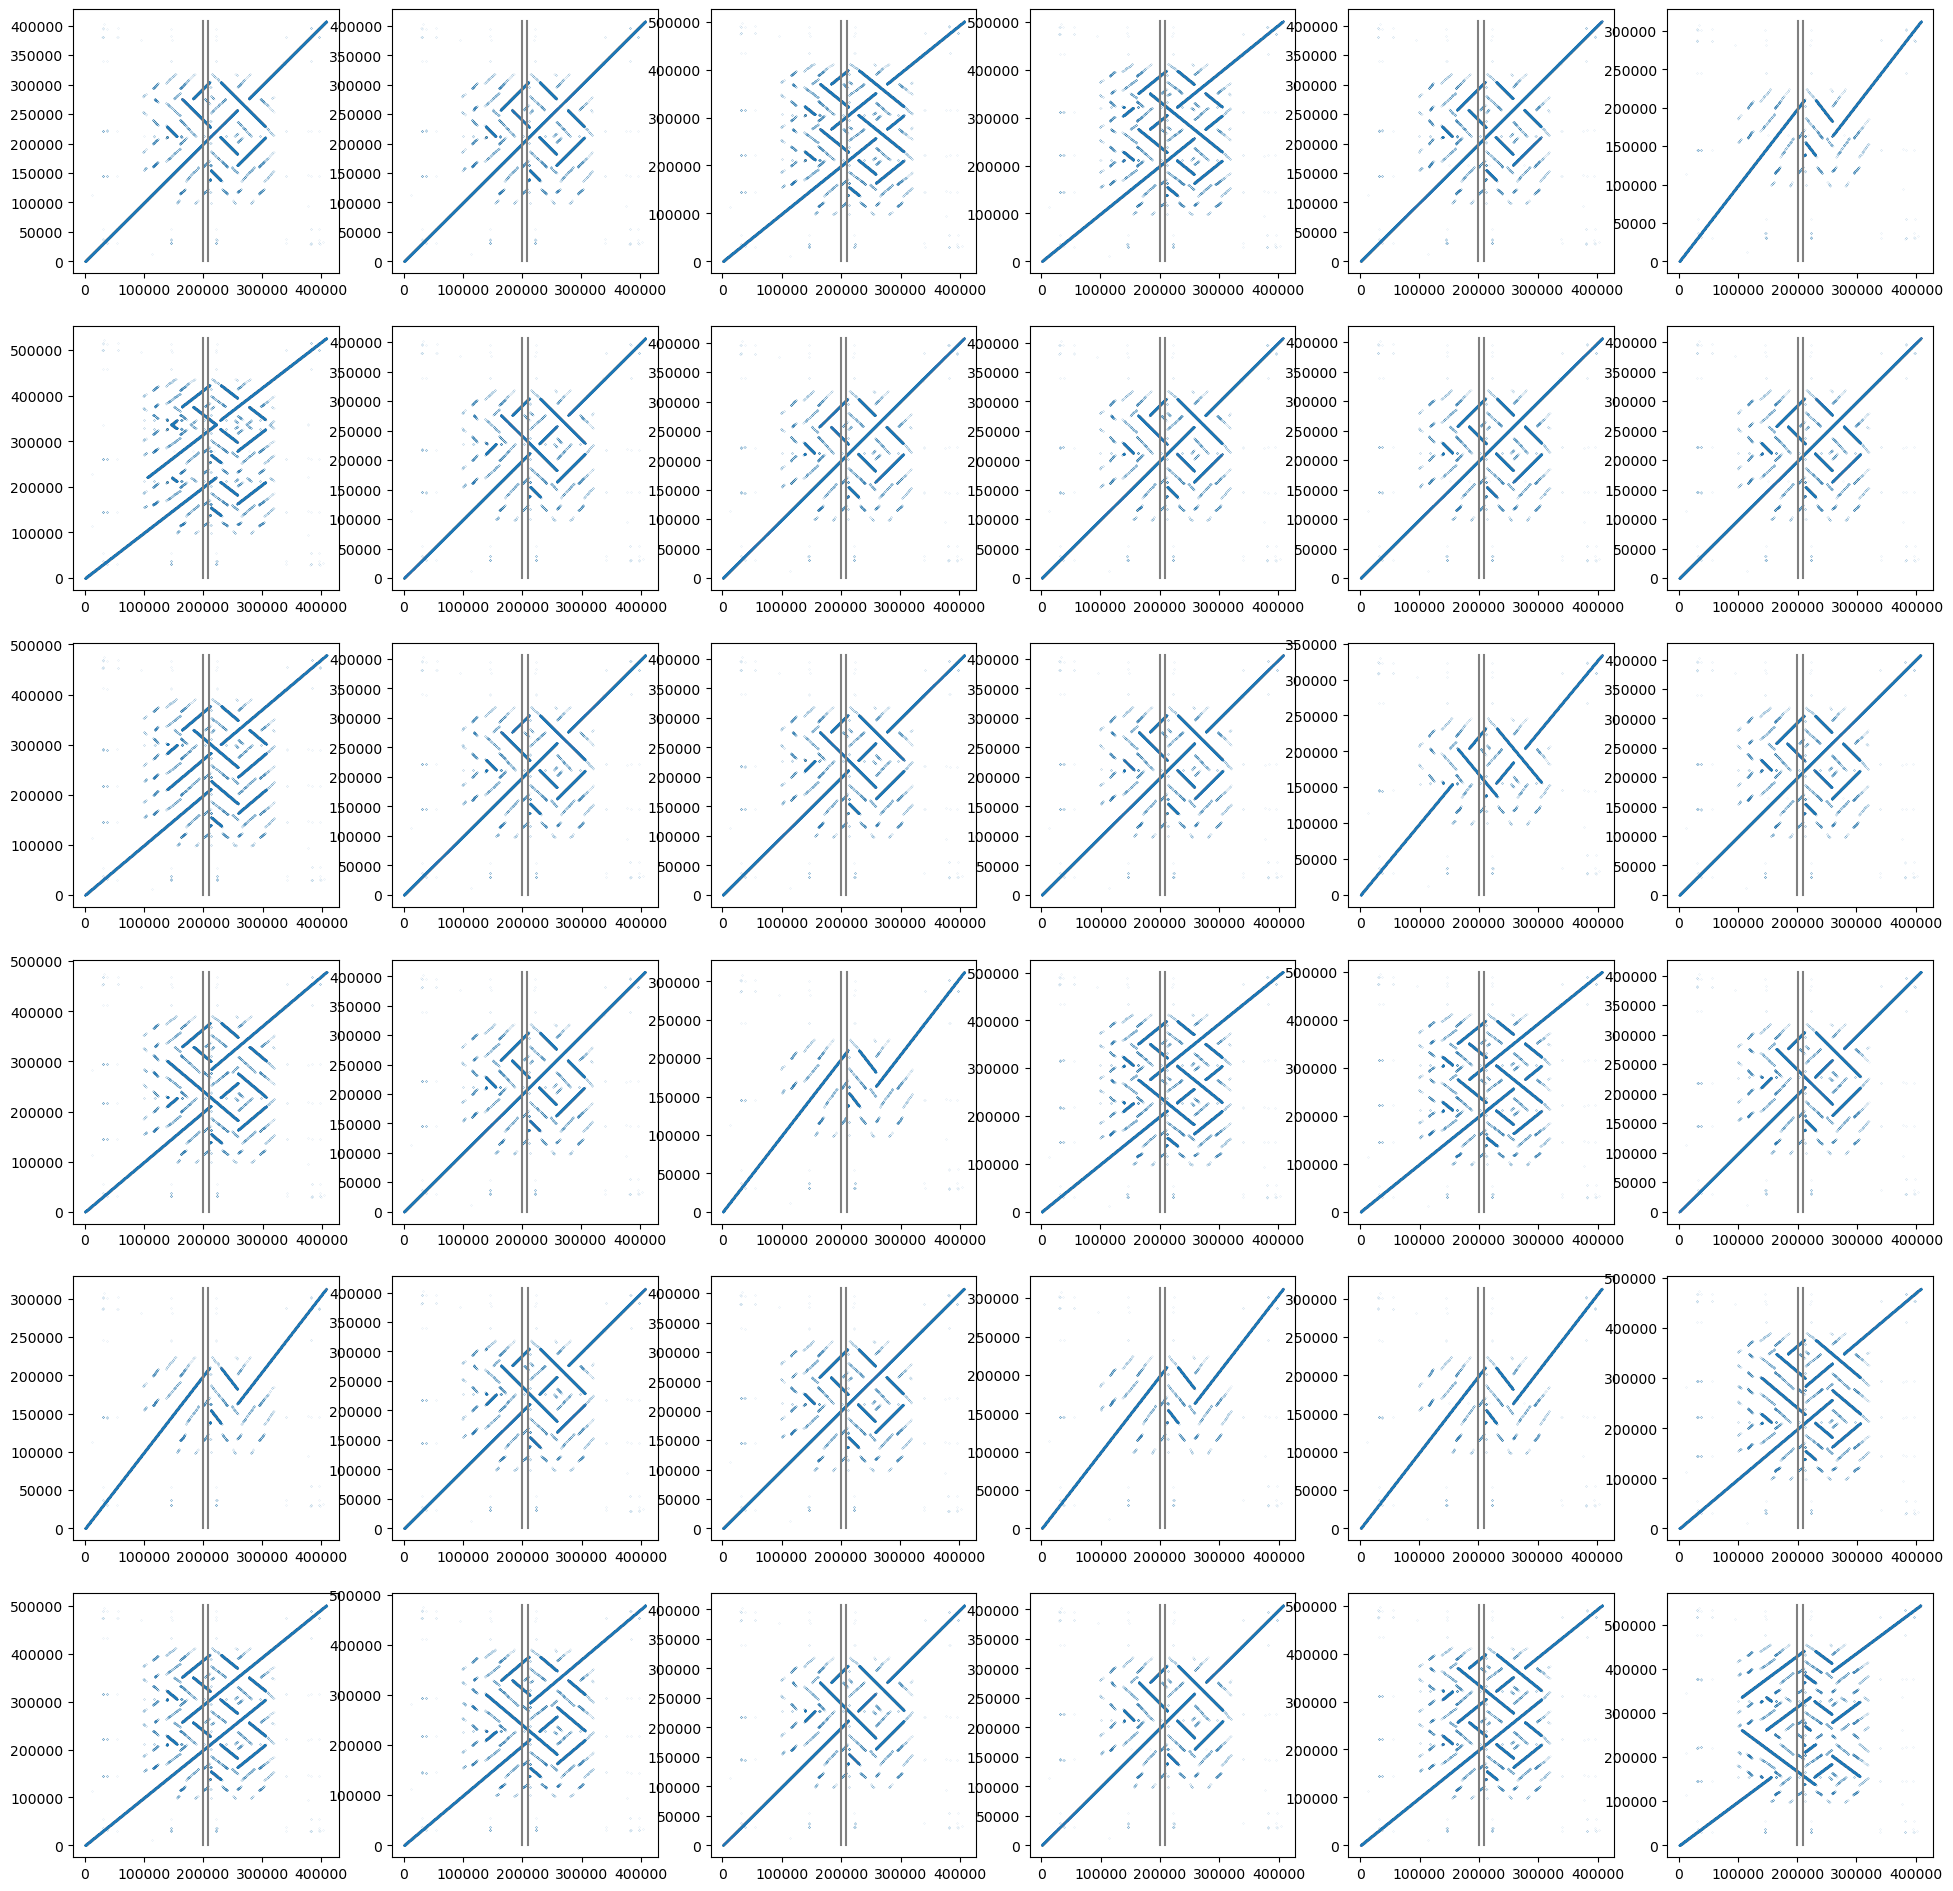

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
            continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 1, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

89

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 89
The total aligned regions is 90


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 88
number of copy: 2, number of haplotypes: 1


Text(0, 0.5, 'count')

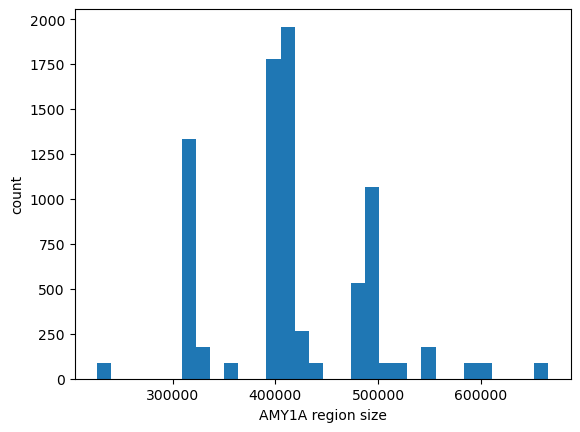

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("AMY1A region size")
plt.ylabel("count")

In [19]:
f0 = open("/results/AMY1A_region_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/AMY1A_region_80_56_6.gfa")
new_sdb.write_mapg_idx("/results/AMY1A_region_80_56_6.gidx")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/AMY1A_region_80_56_2.gfa")
new_sdb.write_mapg_idx("/results/AMY1A_region_80_56_2.gidx")


new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=48, k=56, r=4, min_span=28)
new_sdb.generate_mapg_gfa(0, "/results/AMY1A_region_48_56_4_28.gfa")
new_sdb.write_mapg_idx("/results/AMY1A_region_48_56_4_28.gidx")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Graphviz layout (slow)

## Generate Repeat Pattern Using the Principal Bundles

In [25]:
shmmrspec = {"w": 48, "k":56, "r":4, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])


In [26]:
help(new_sdb.get_principal_bundle_decomposition)

Help on built-in function get_principal_bundle_decomposition:

get_principal_bundle_decomposition(...) method of builtins.SeqIndexDB instance
    Get the principal bundles and bundle decomposition of all seqeuences
    
    Parameters
    ----------
    min_count : int
        minimum coverage count to be included in the graph
    
    path_len_cut_off : int
        remove short path less than path_len_cut_off when generating the principal path
        
        if the number is small, the generated principal paths will be more fragemented.
     
    Returns
    -------
    tuple
        a tuple consist of two lists: (principal_bundles, seqid_smps_with_bundle_id_seg_direction)
     
        principal_bundles = list of (principal_bundle_id, ave_bundle_position, list_bundle_vertex)
       
        list_of_bundle_vertex = list of (hash0:u64, hash0:u64, direction:u8)
    
        seqid_smps_with_bundle_id_seg_direction = list of shimmer pairs in the database annotated with principal bundle 

In [27]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

28


In [28]:
import numpy as np
from matplotlib import cm

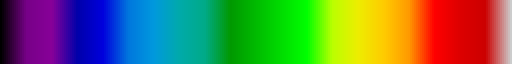

In [29]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [30]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0  3  6  9 12 15 18 21 24 27  2  5  8 11 14 17 20 23 26  1  4  7 10 13
 16 19 22 25]


In [31]:
gene_matches = new_sdb.get_match_positions_with_fragment(gene_seq)

In [32]:
from matplotlib.colors import to_hex as to_hex

In [33]:
new_sdb.generate_principal_mapg_gfa(0, 8, "/results/AMY1A_principal.gfa")

v_to_name = {}
v_to_bundle_id = {}
with open("/results/AMY1A_principal.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/AMY1A_principal_color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in principal_bundles:
    bundle_id = bundle[0]
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = to_hex(color_theme[bundle_id])
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, bundle_id, file=f, sep=",")
f.close()


new_sdb.generate_mapg_gfa(0, "/results/AMY1A.gfa")

v_to_name = {}
v_to_bundle_id = {}
with open("/results/AMY1A.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/AMY1A_color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in principal_bundles:
    bundle_id = bundle[0]
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = to_hex(color_theme[bundle_id])
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, bundle_id, file=f, sep=",")
f.close()

In [34]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

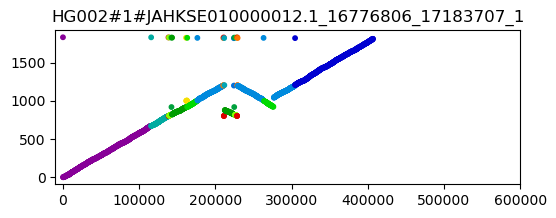

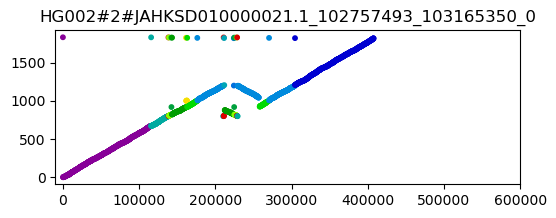

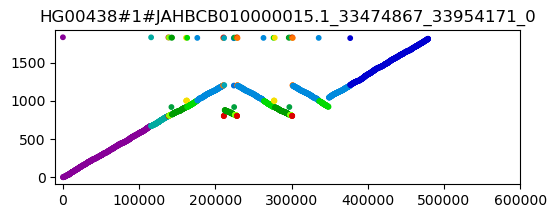

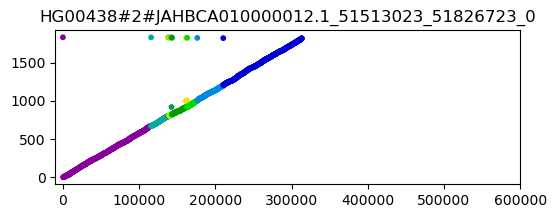

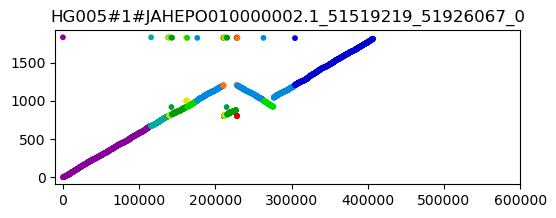

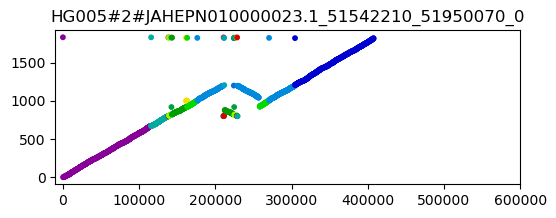

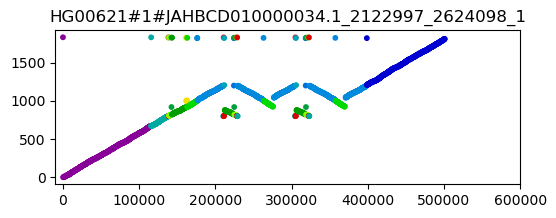

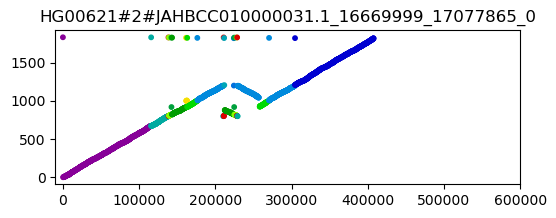

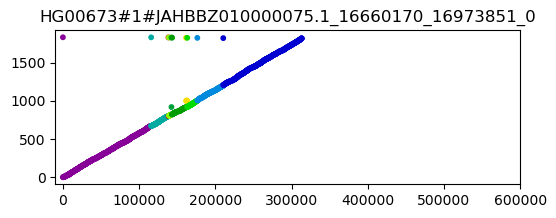

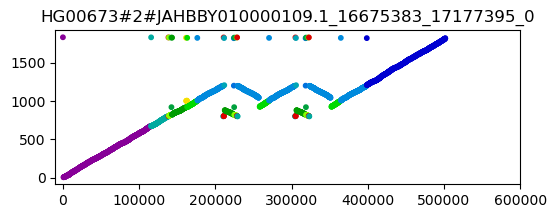

In [35]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,600000)
    plt.title(ctg)
    

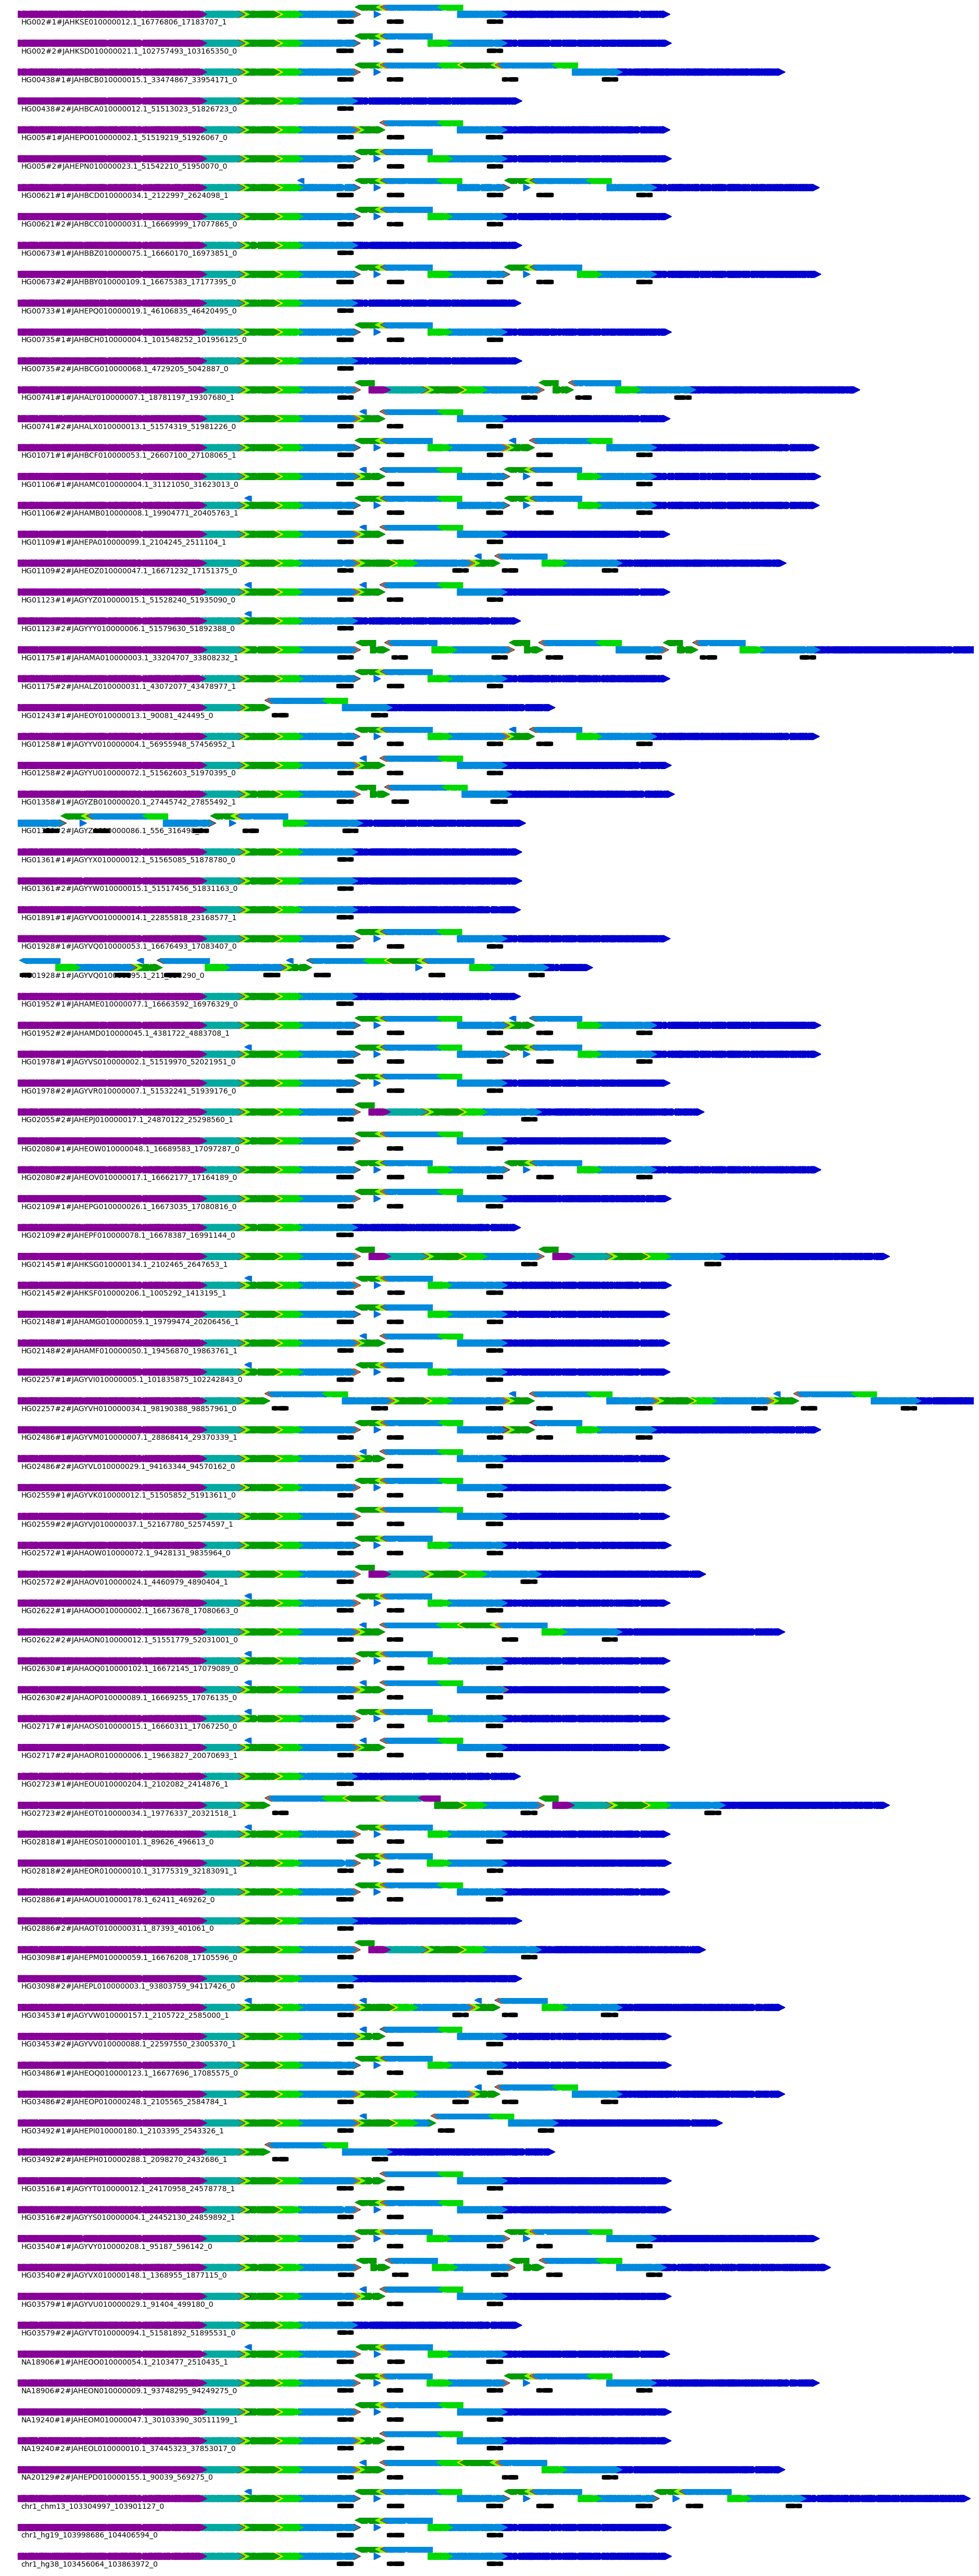

In [36]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
    matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    #plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color=track0_c, s=20)
    
    track0_x = [_[0] for _ in gene_matches[sid]]
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,600000)
    plt.text(0, -8, ctg)

/tmp/ipykernel_10145/3154699274.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,2))


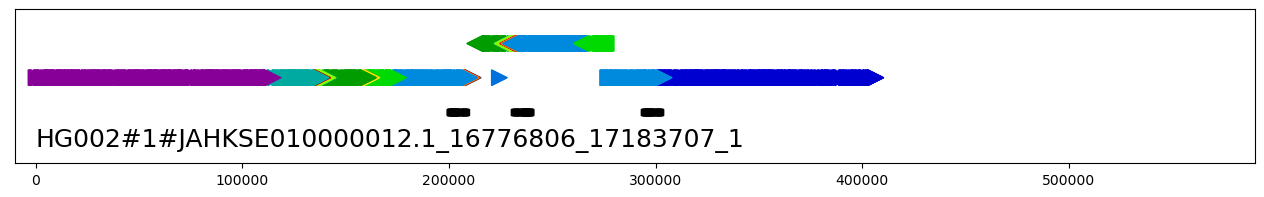

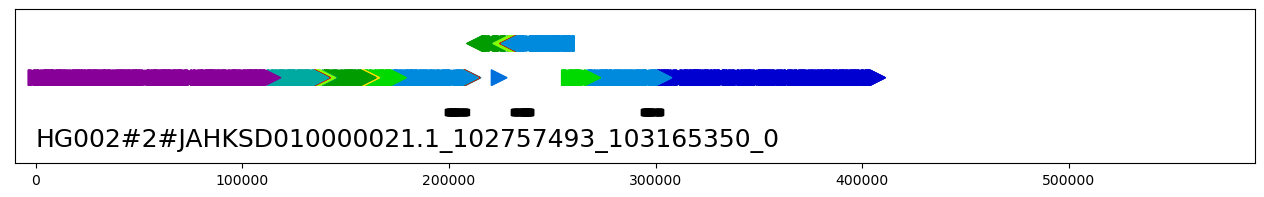

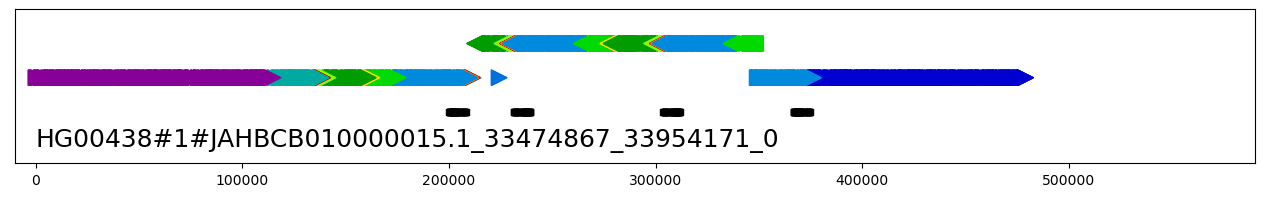

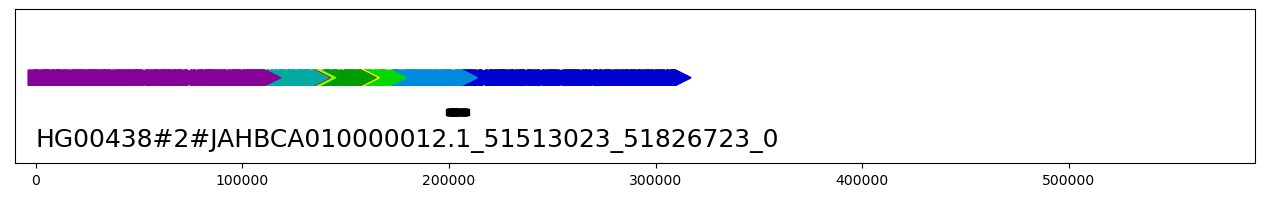

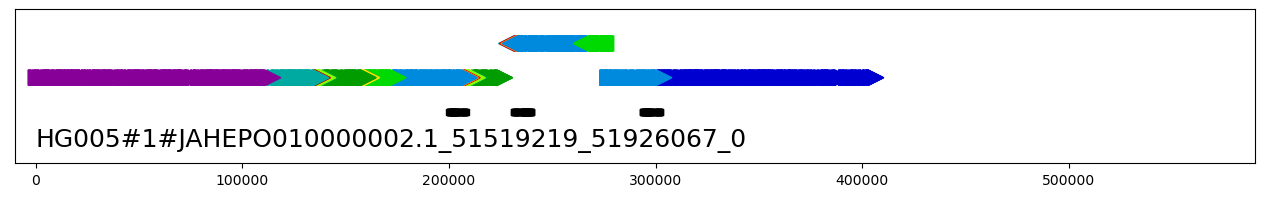

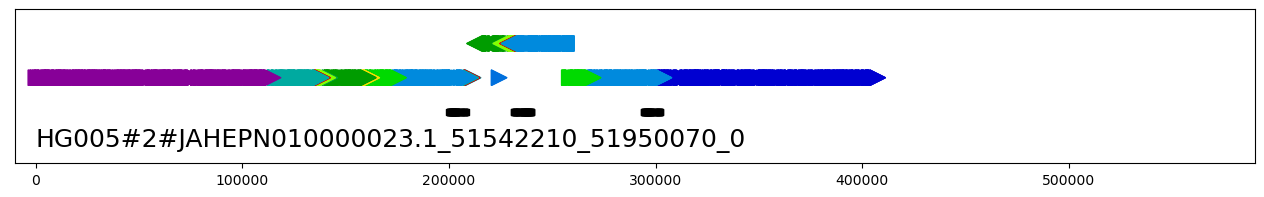

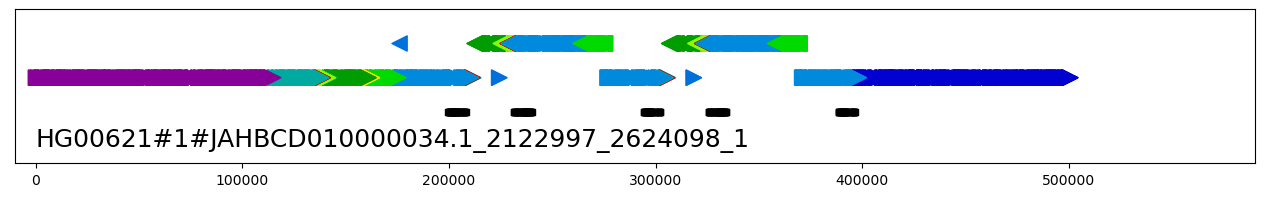

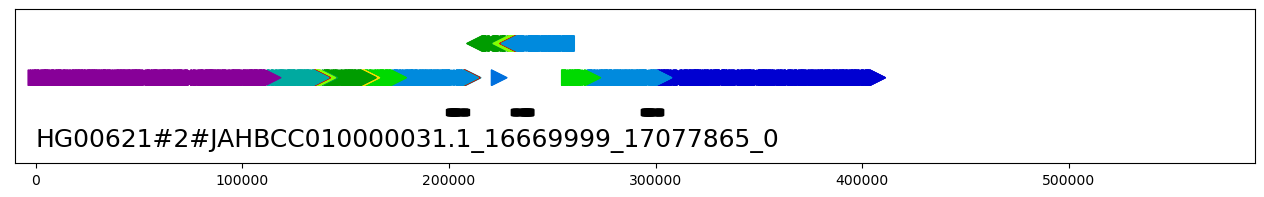

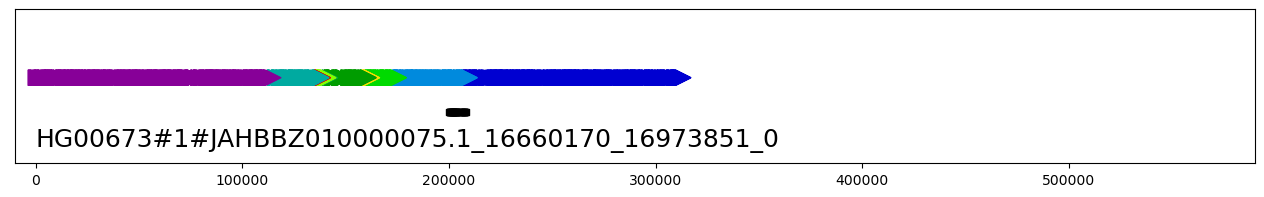

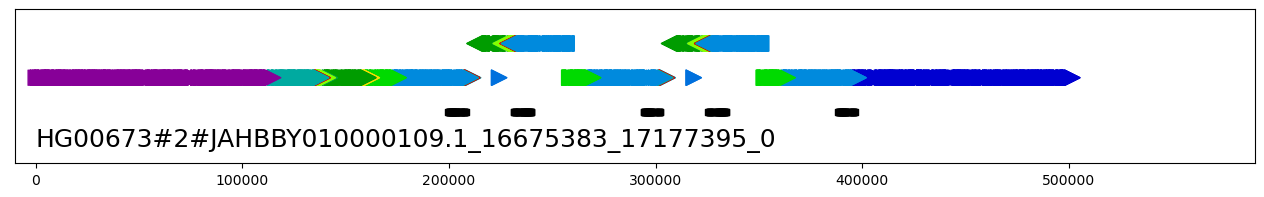

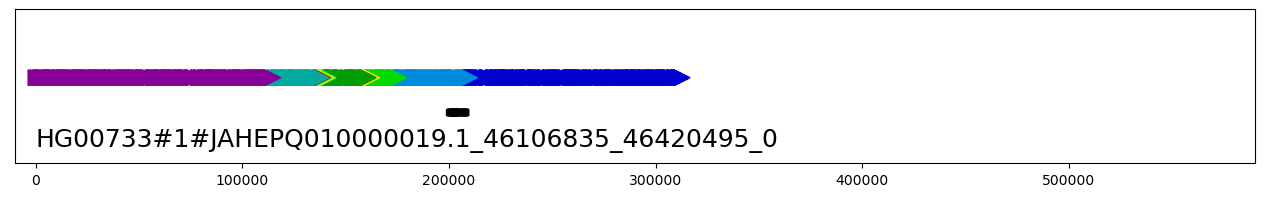

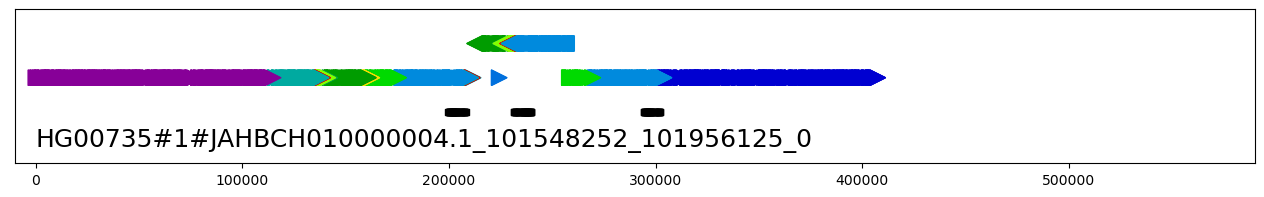

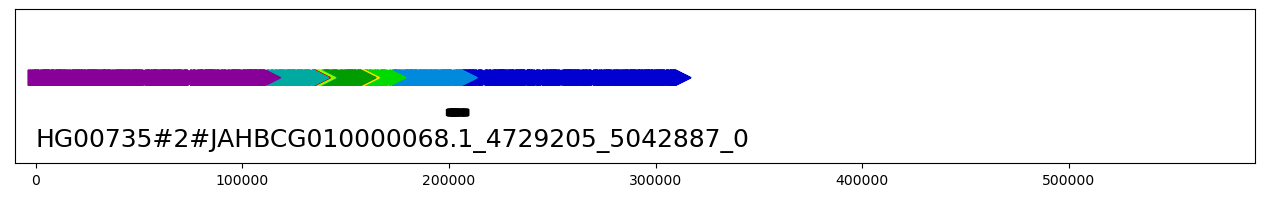

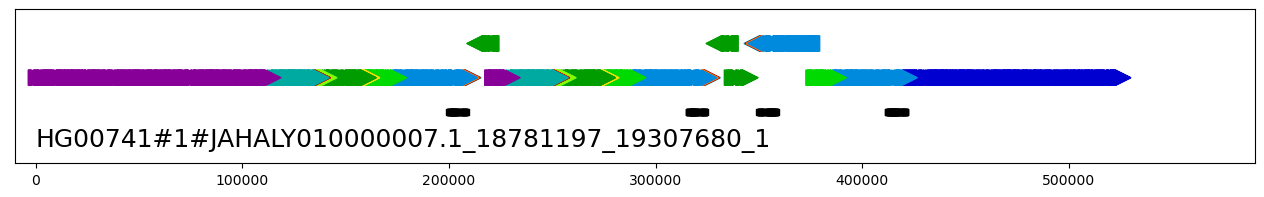

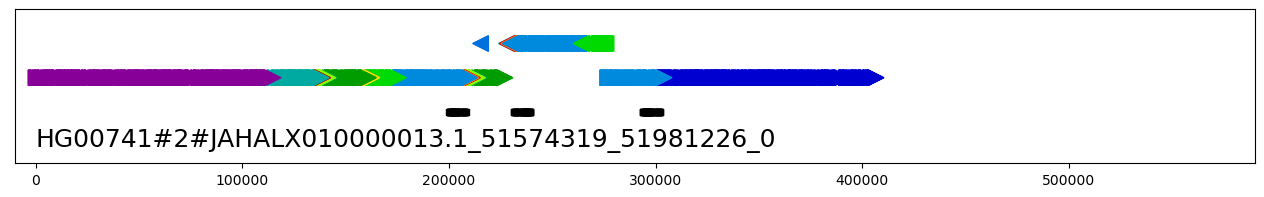

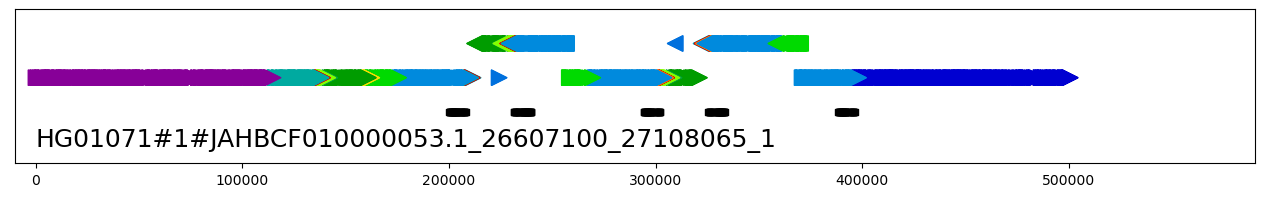

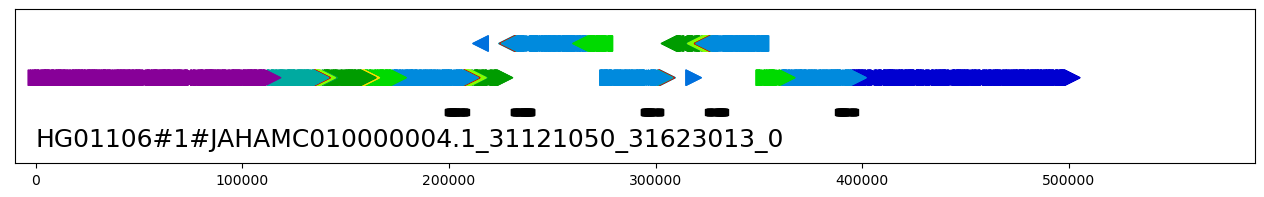

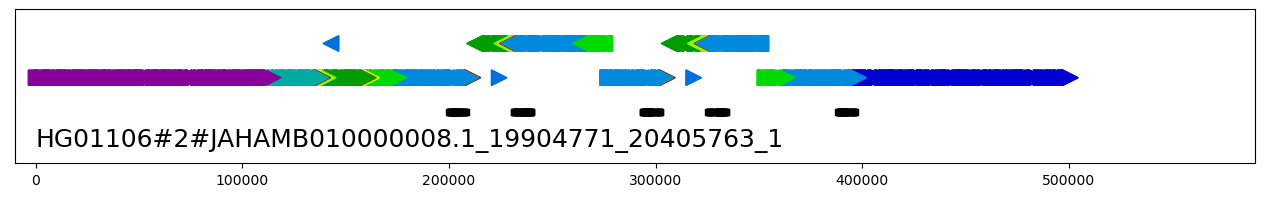

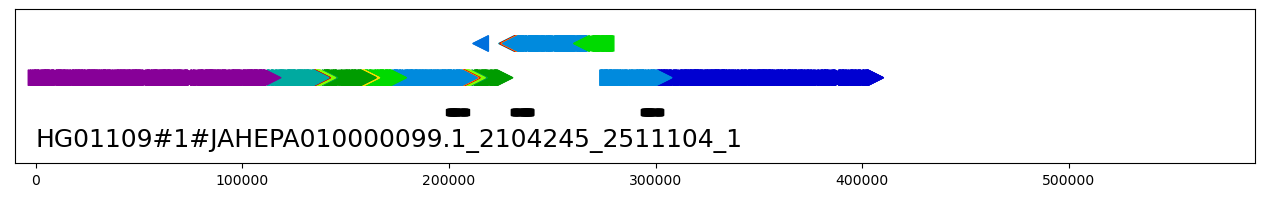

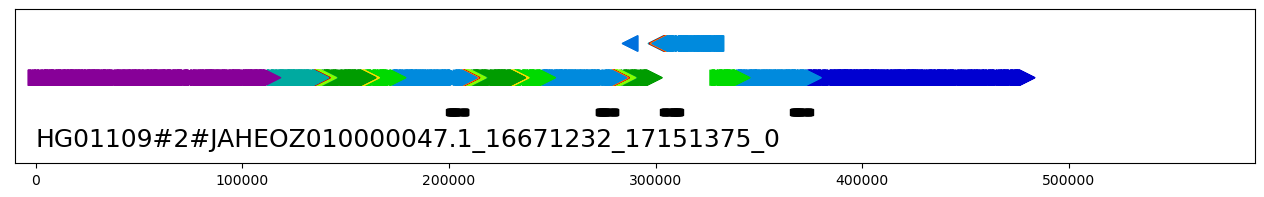

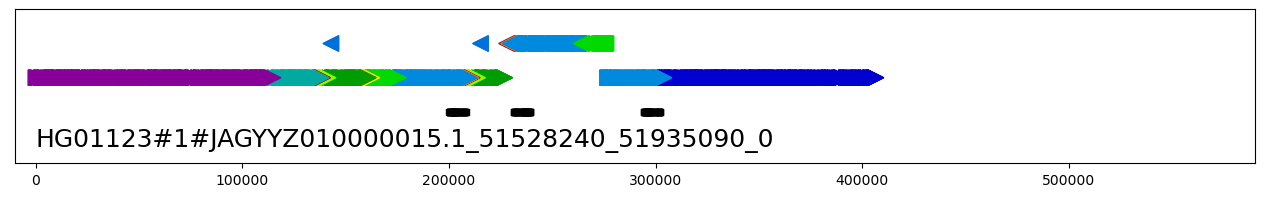

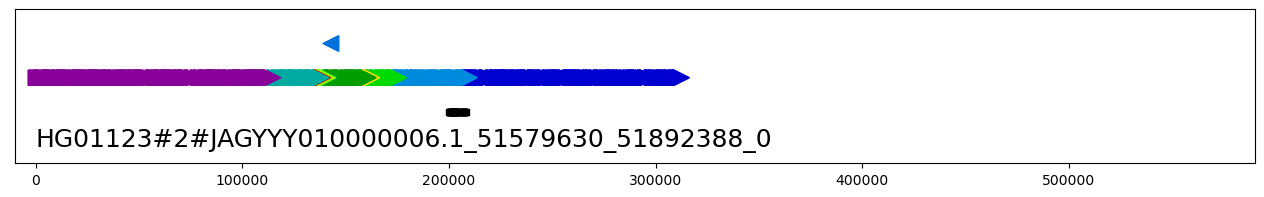

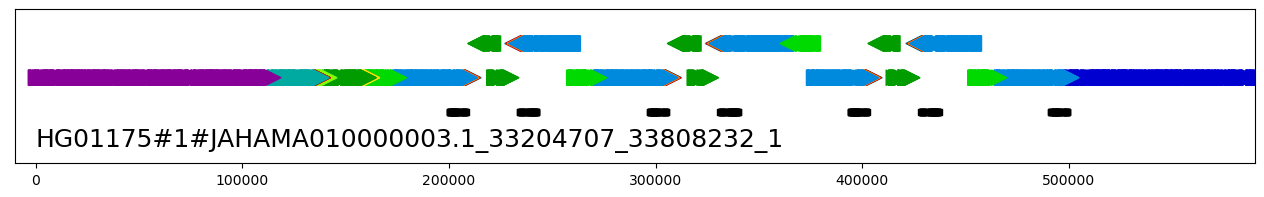

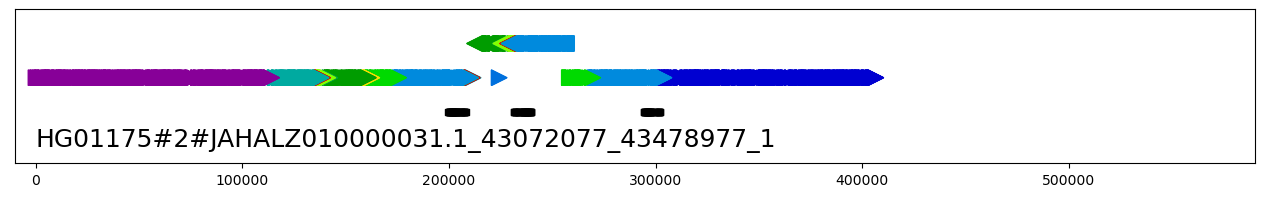

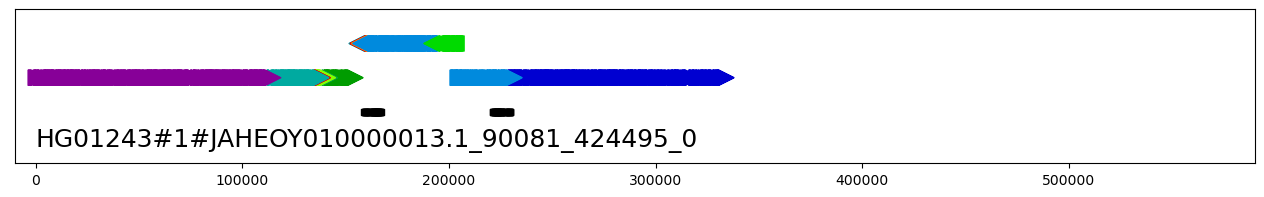

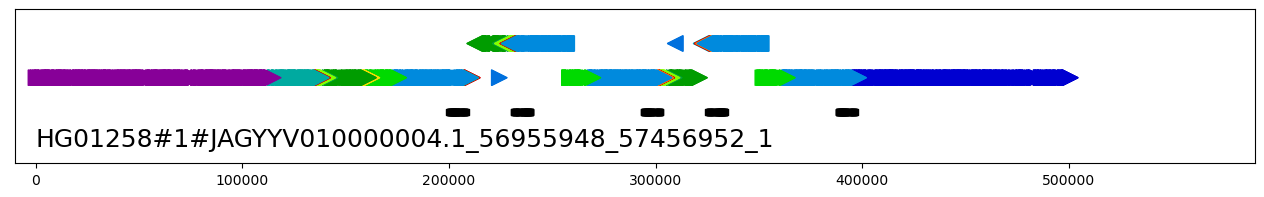

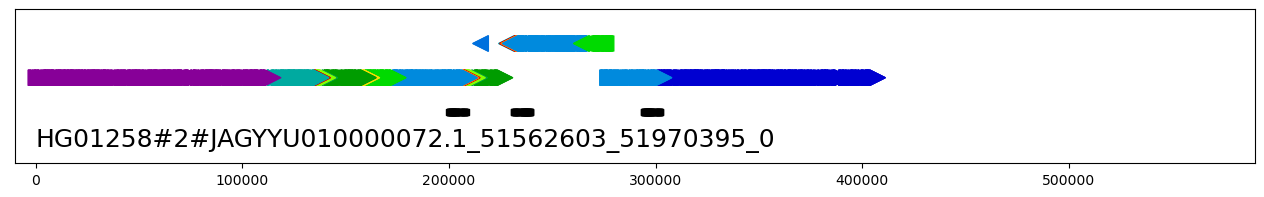

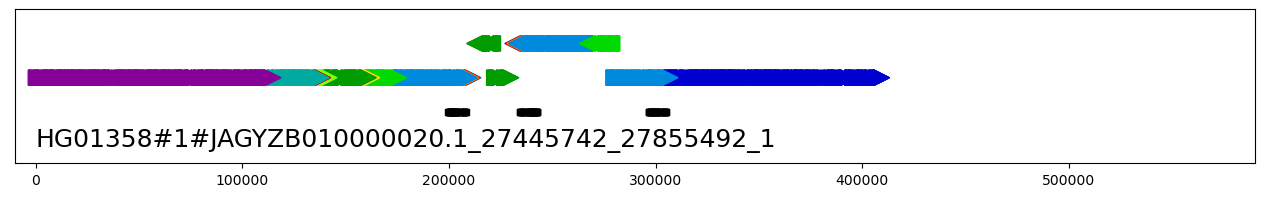

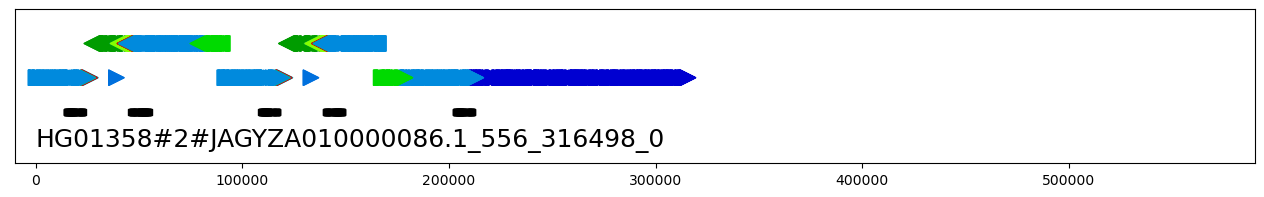

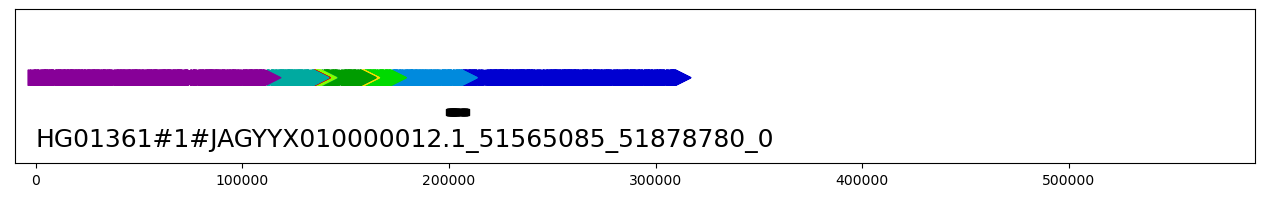

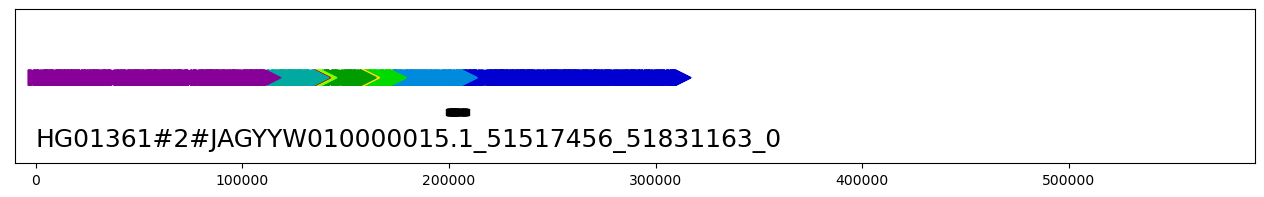

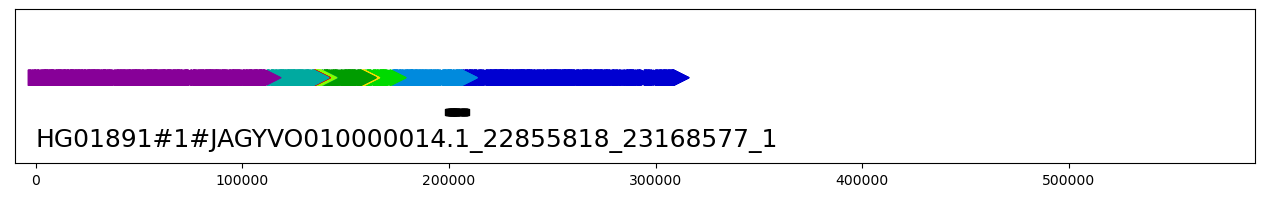

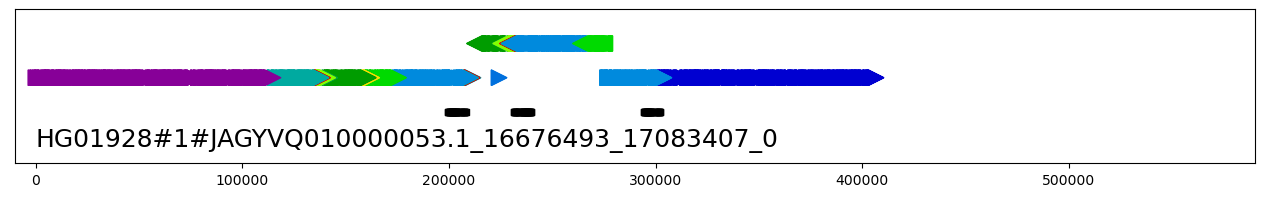

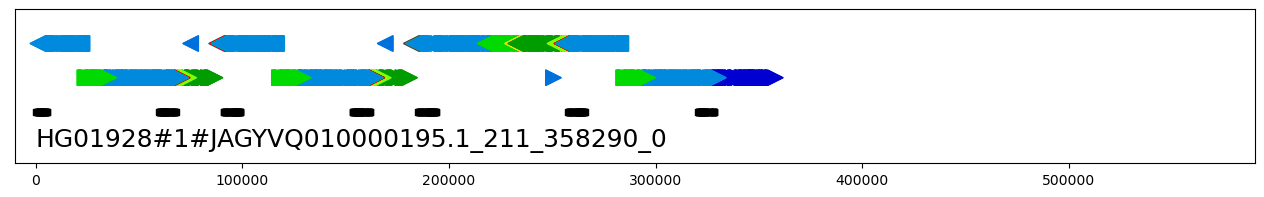

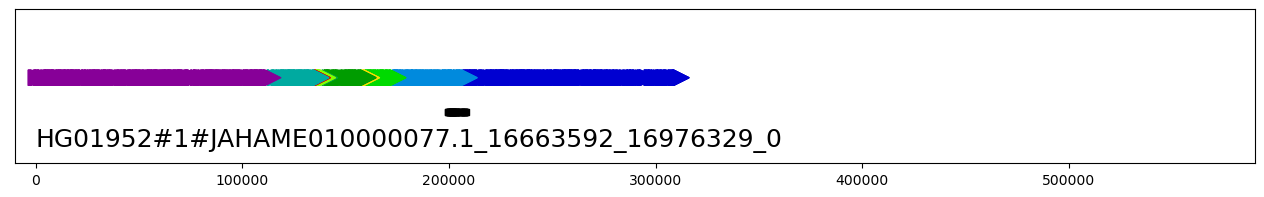

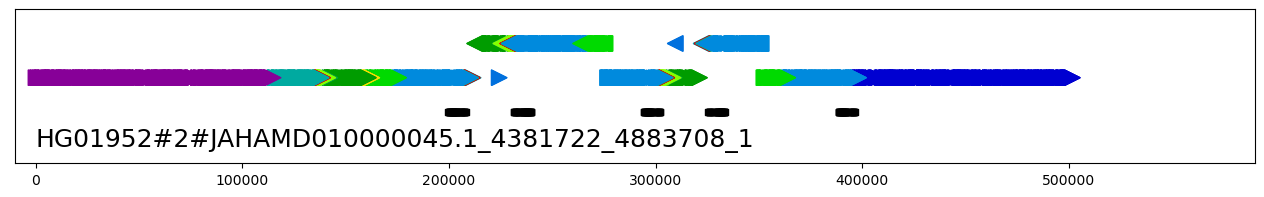

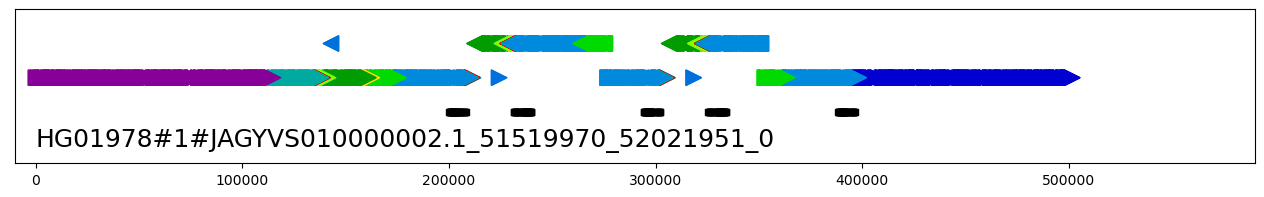

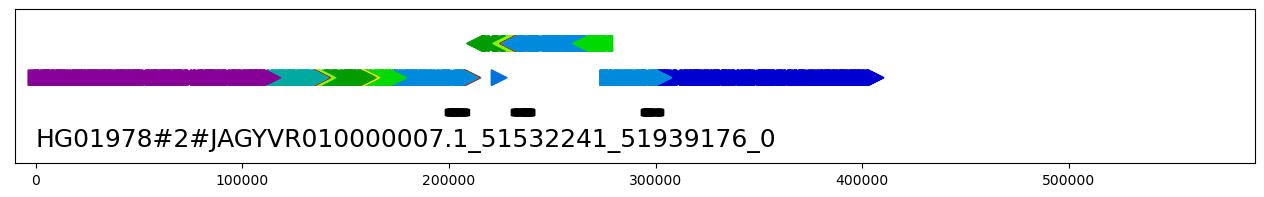

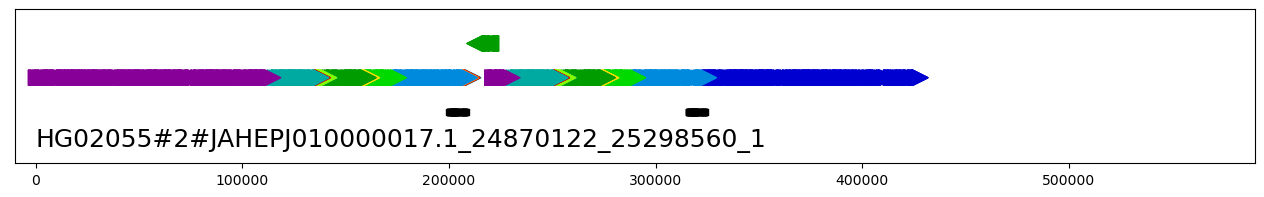

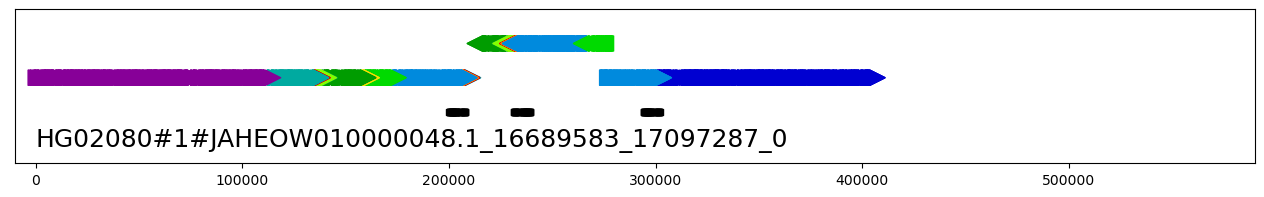

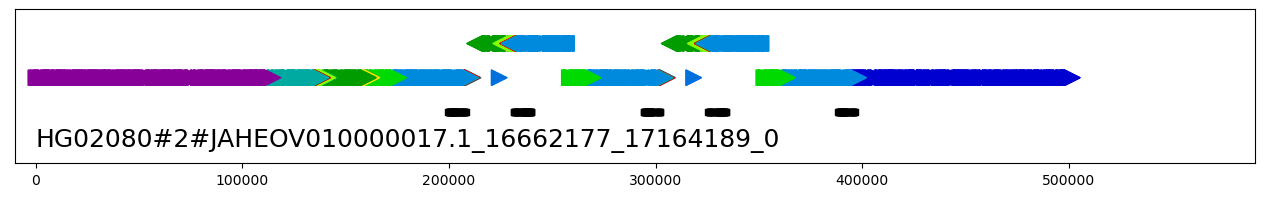

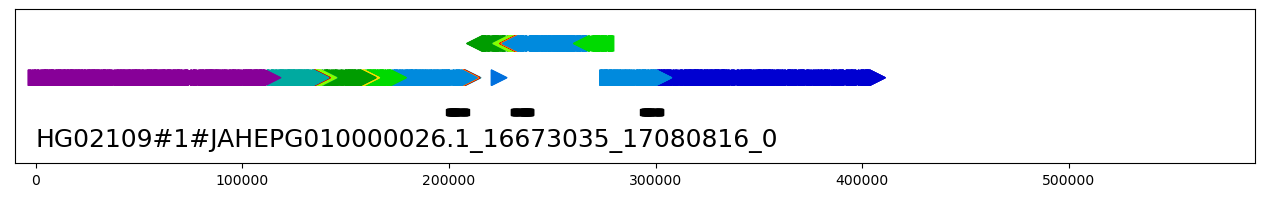

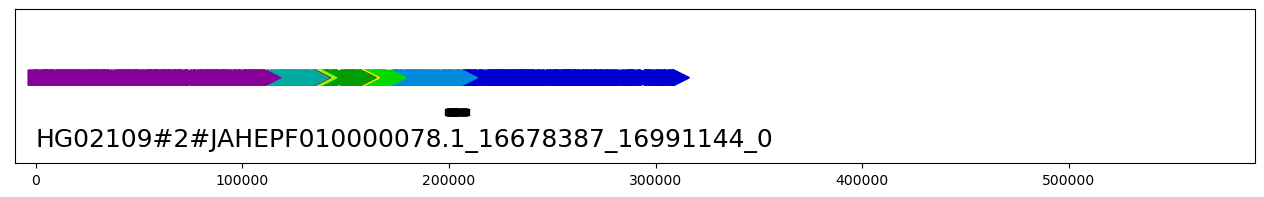

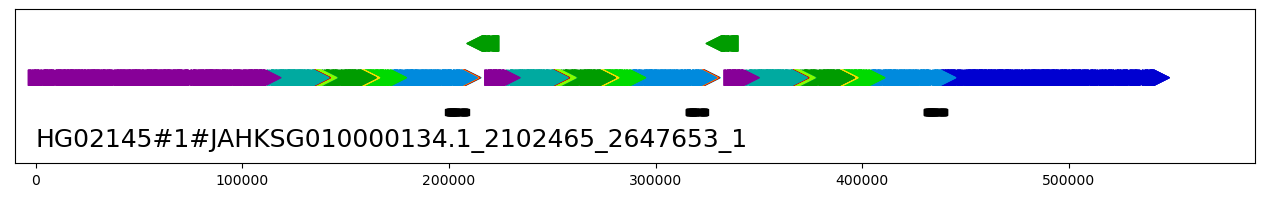

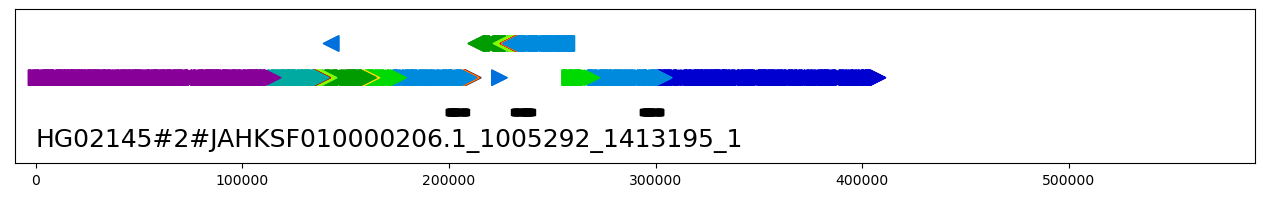

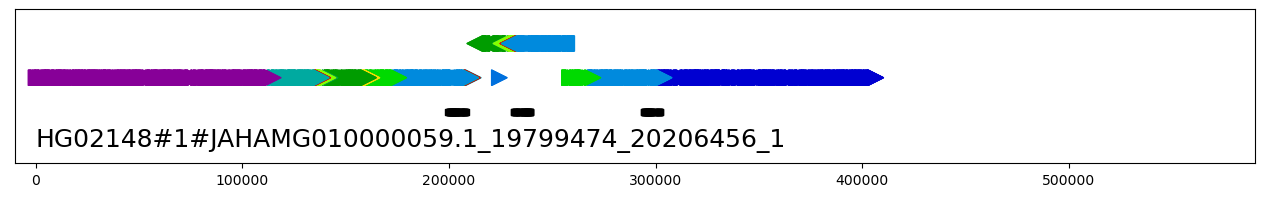

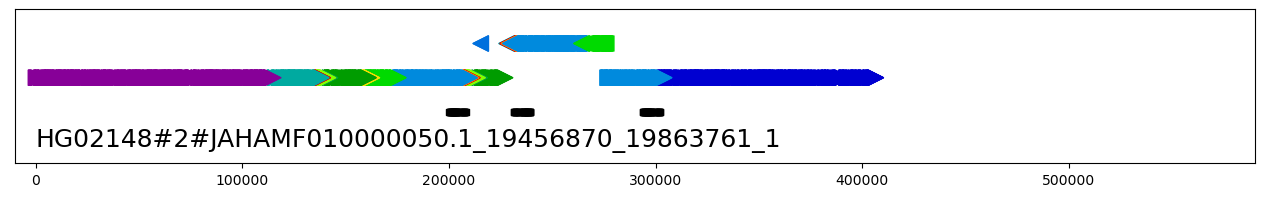

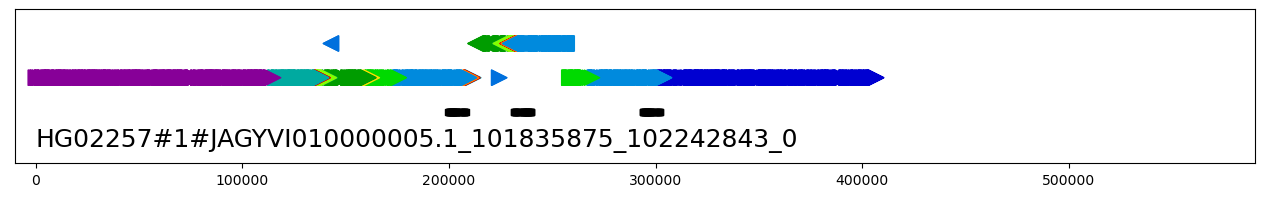

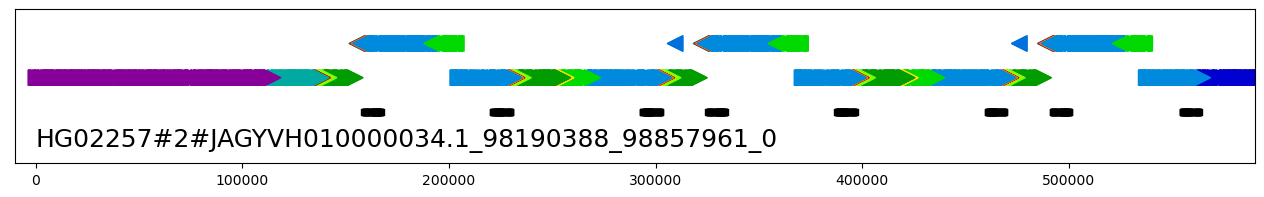

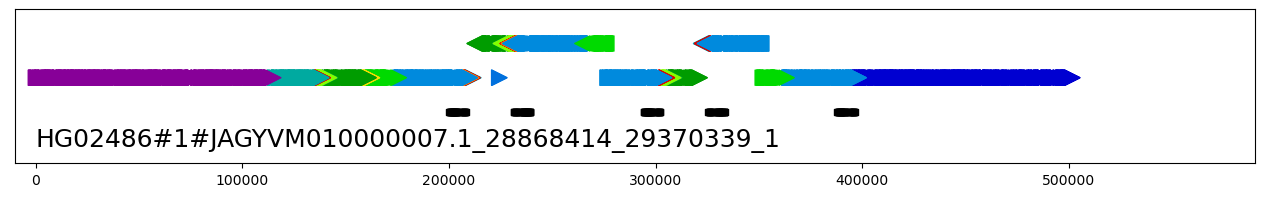

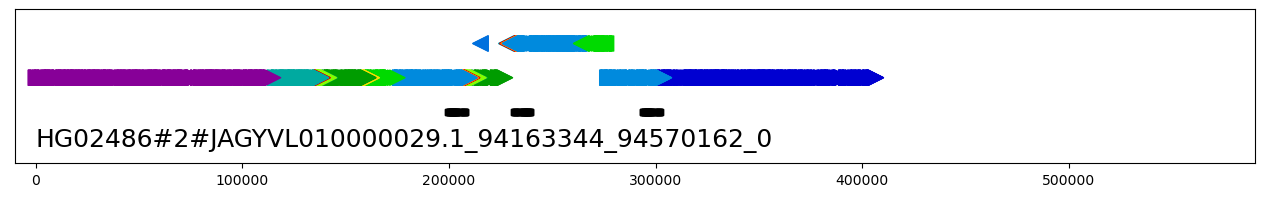

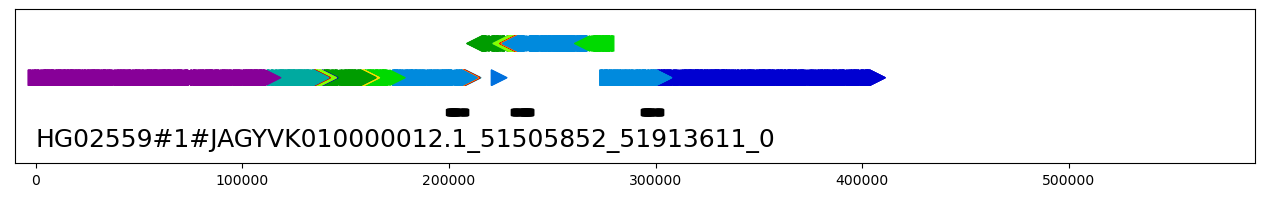

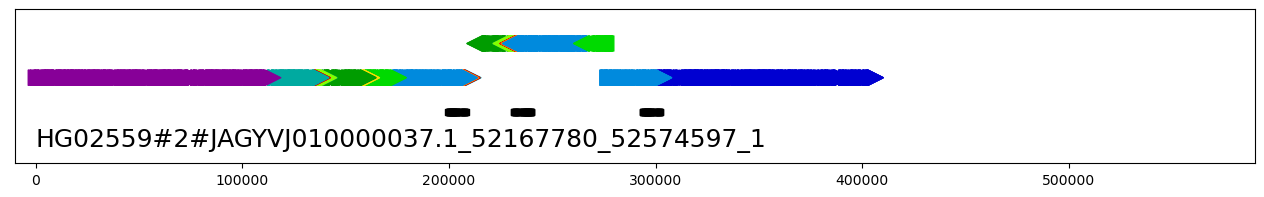

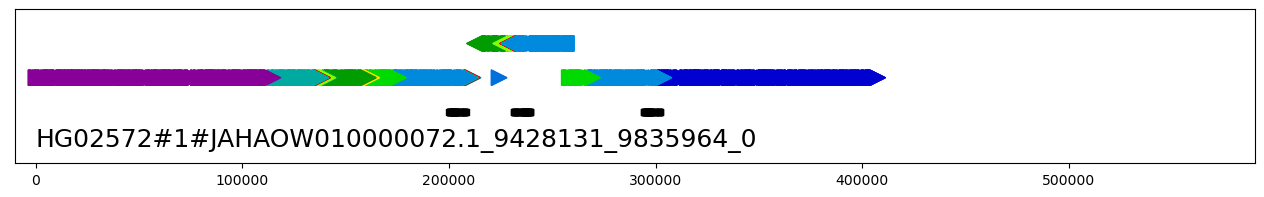

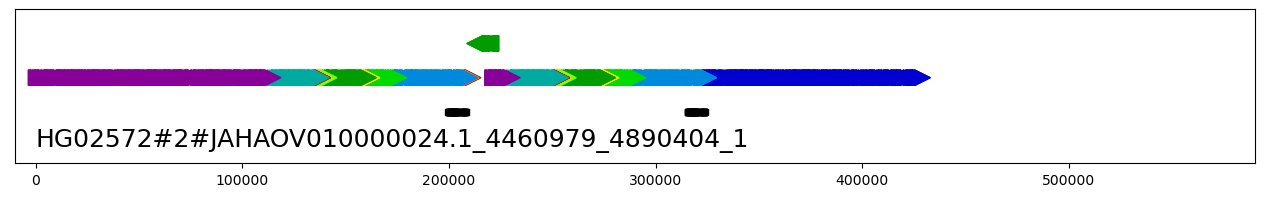

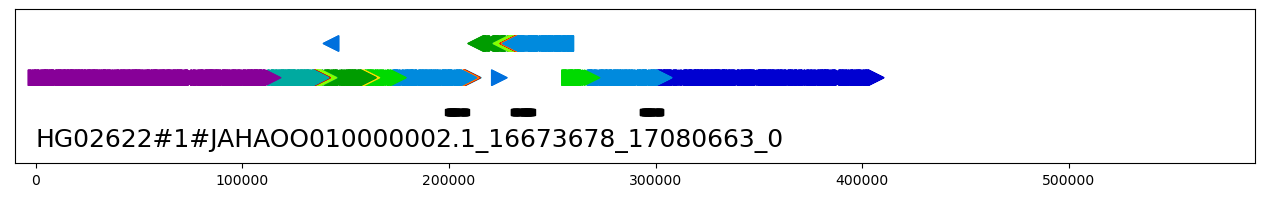

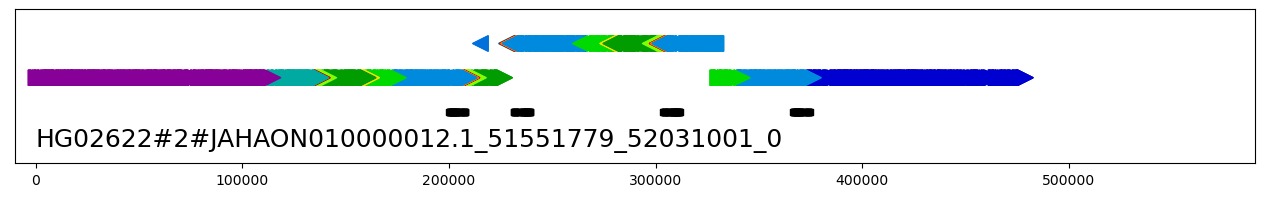

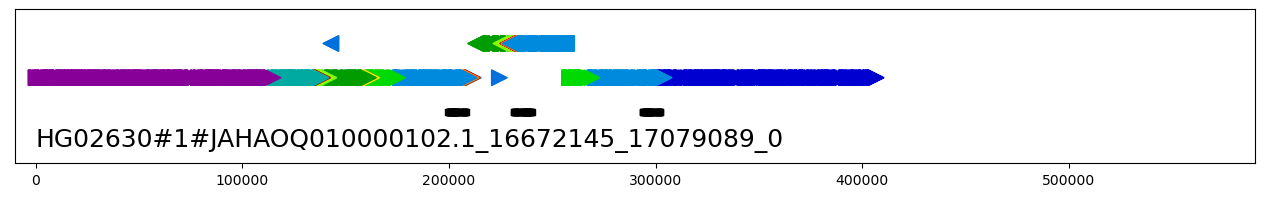

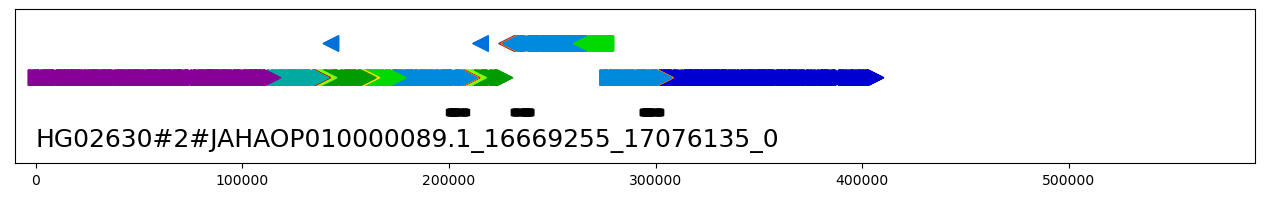

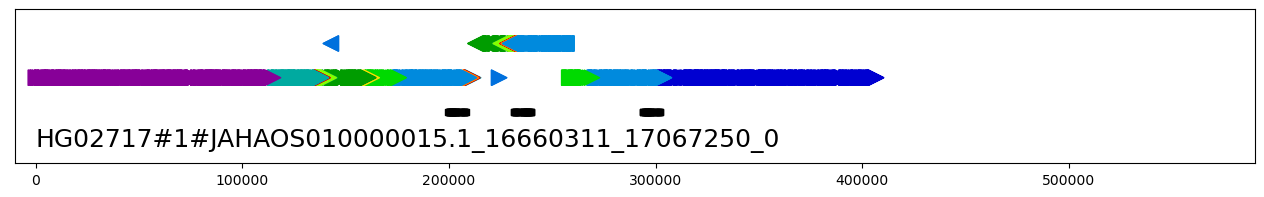

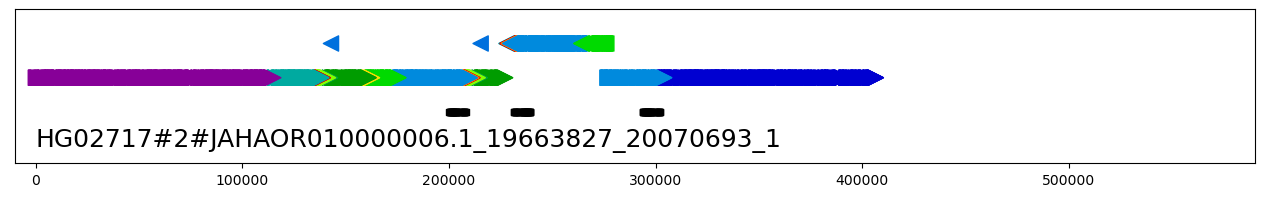

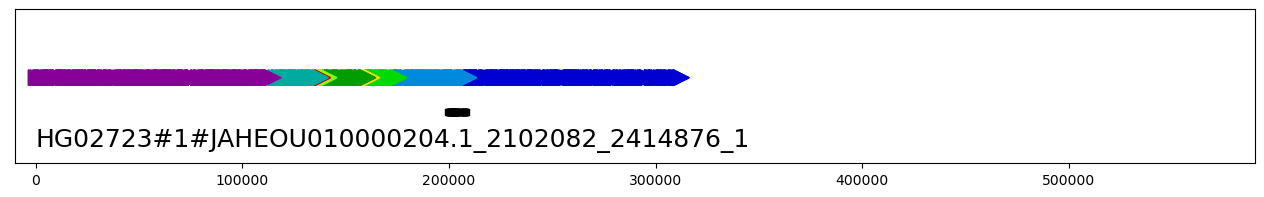

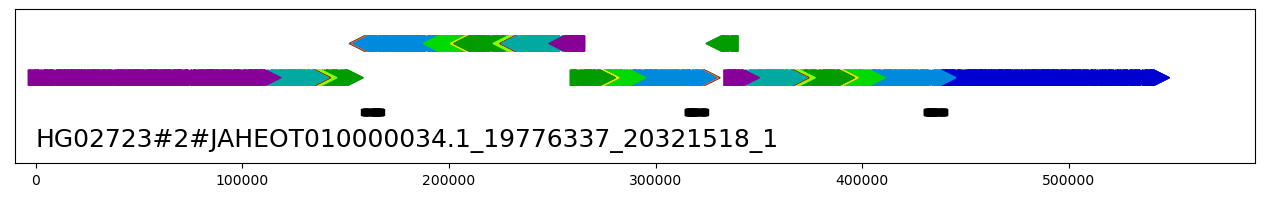

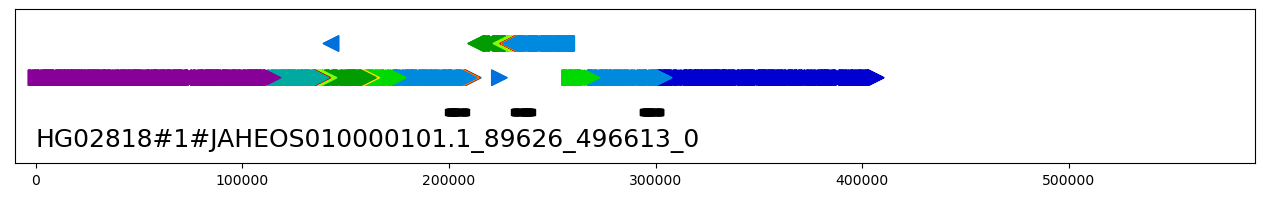

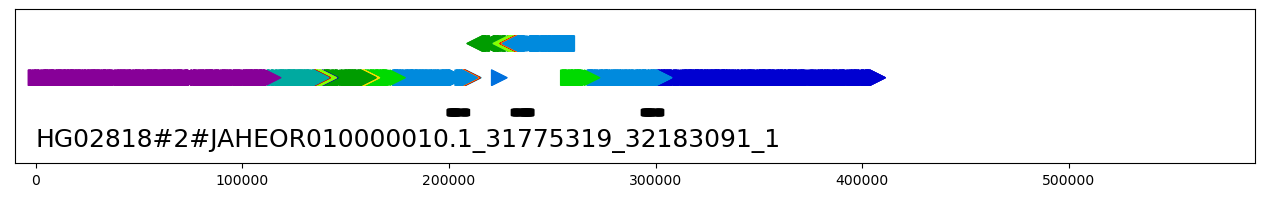

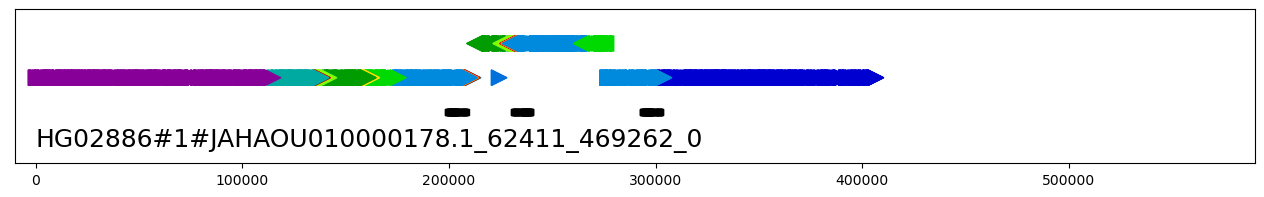

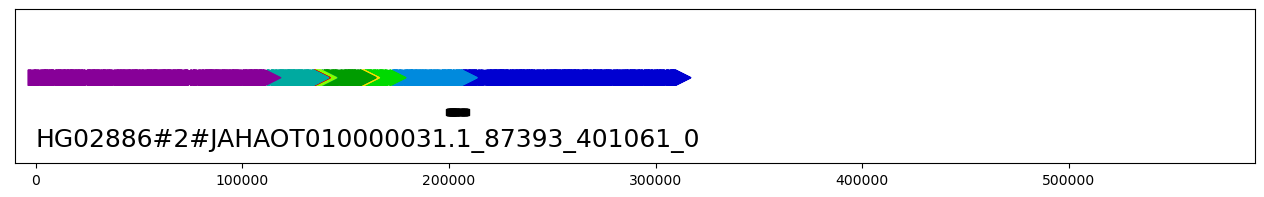

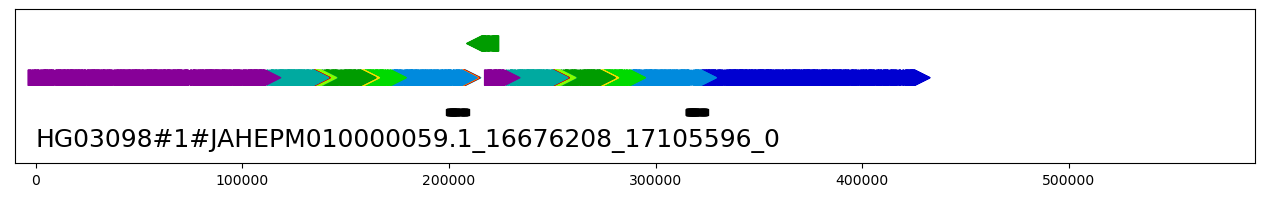

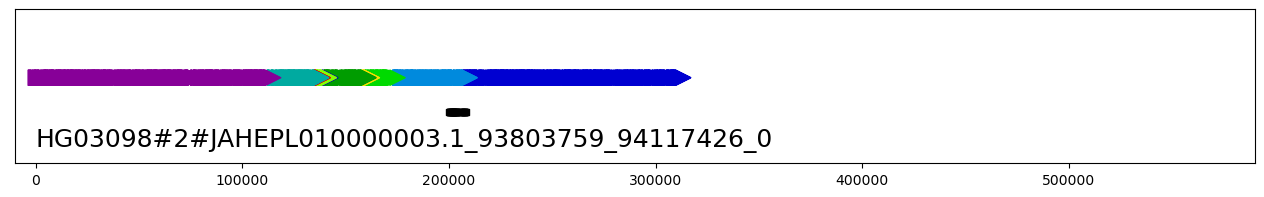

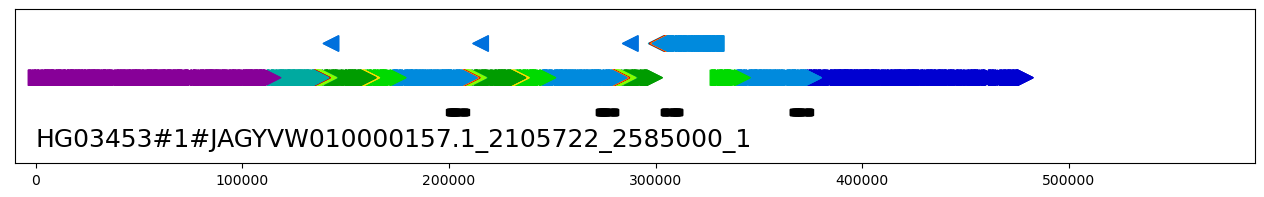

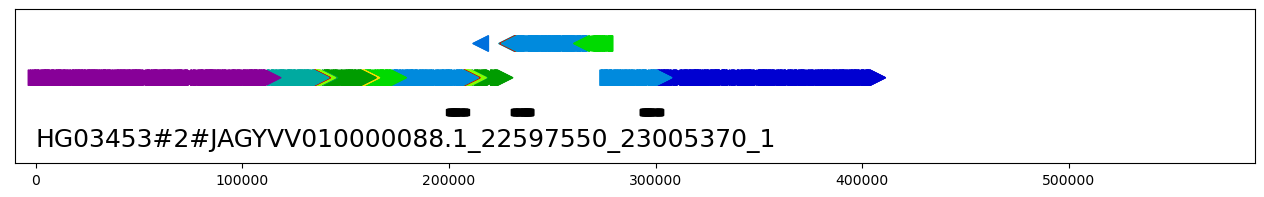

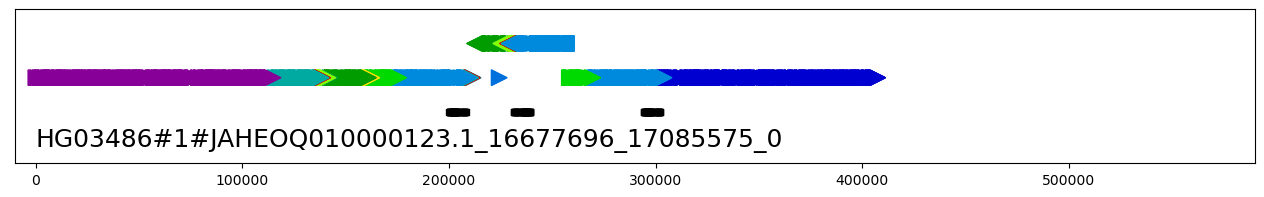

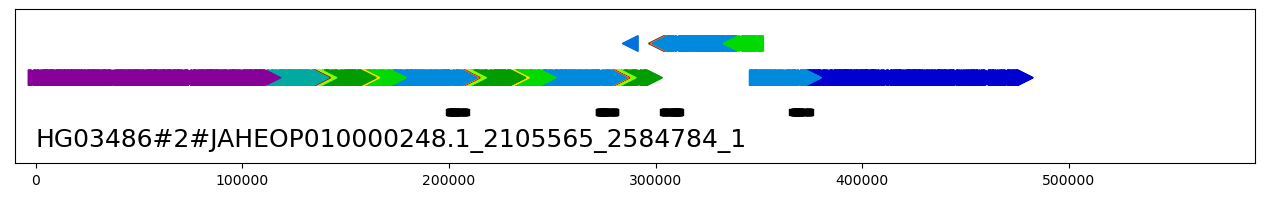

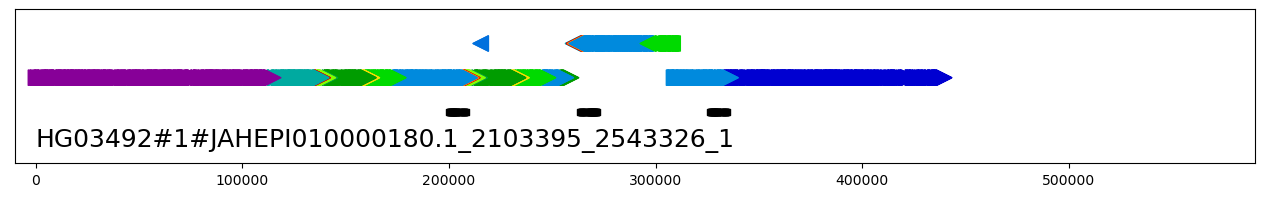

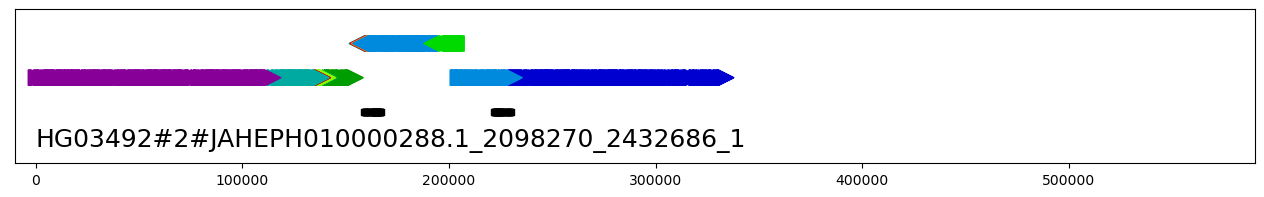

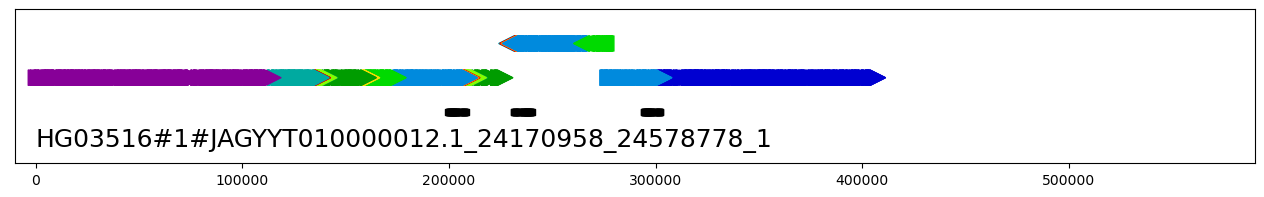

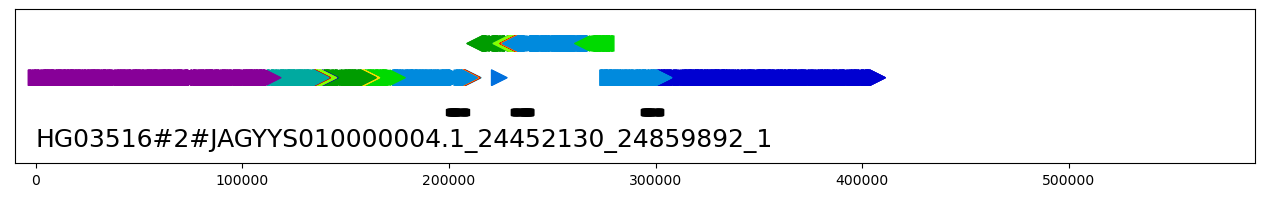

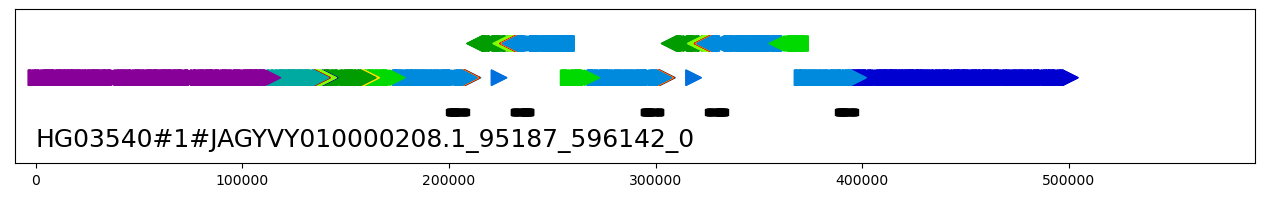

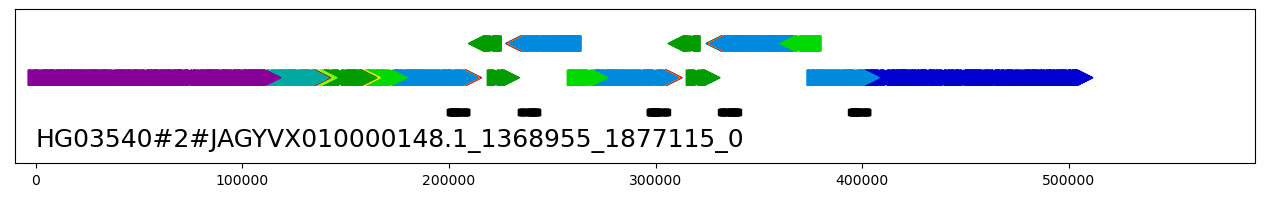

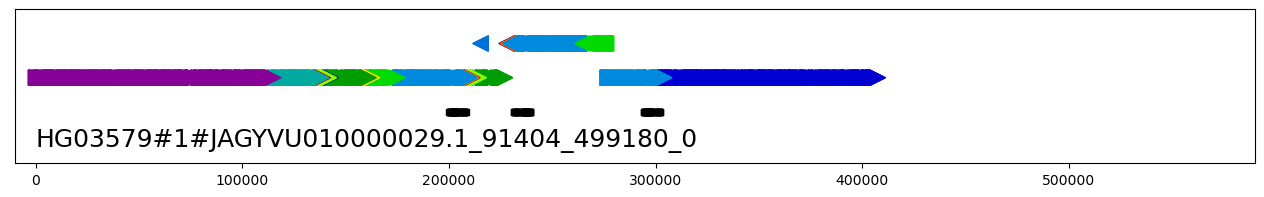

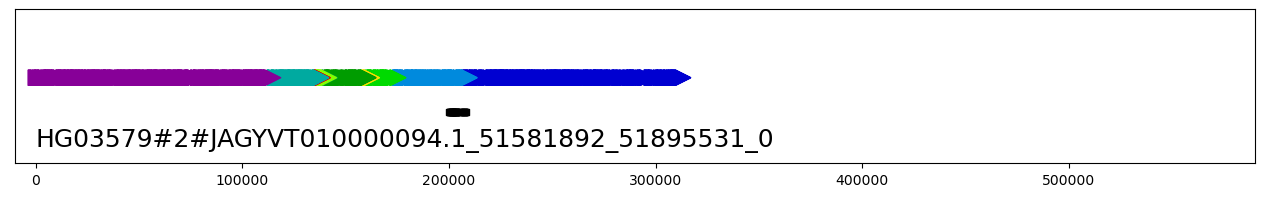

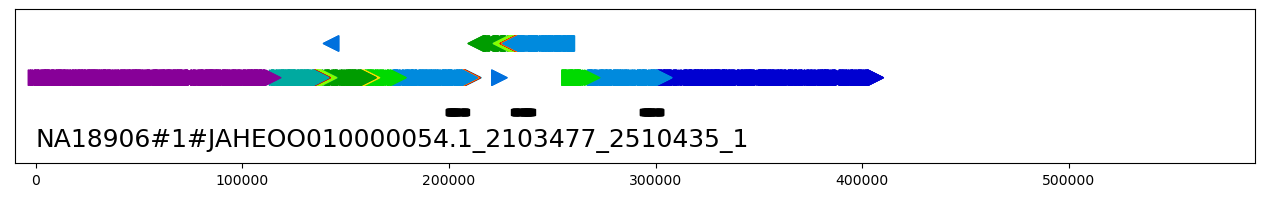

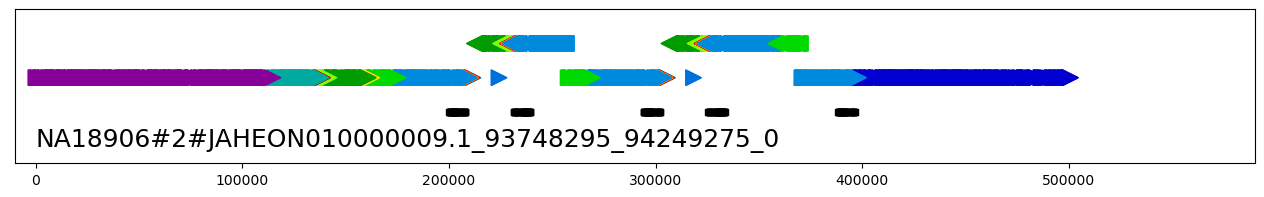

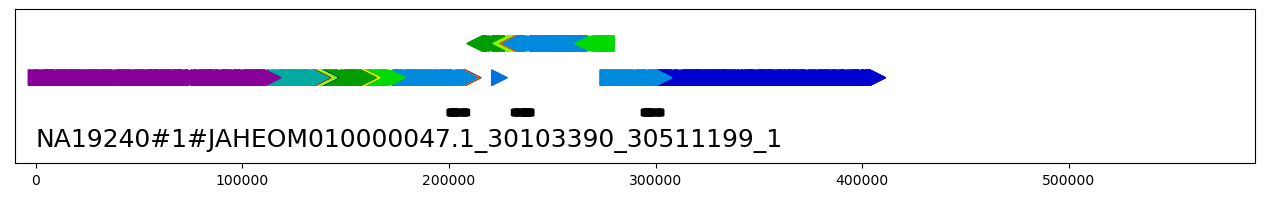

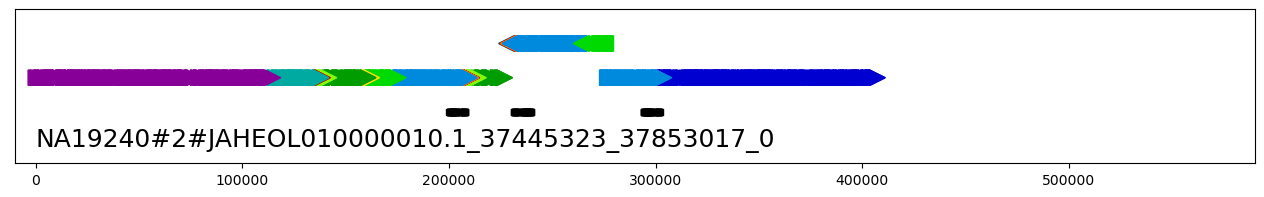

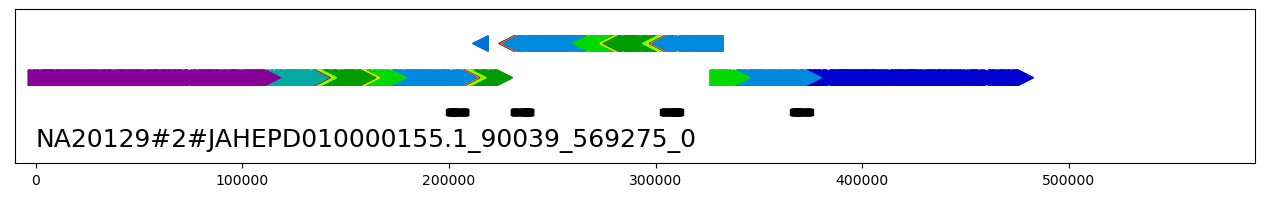

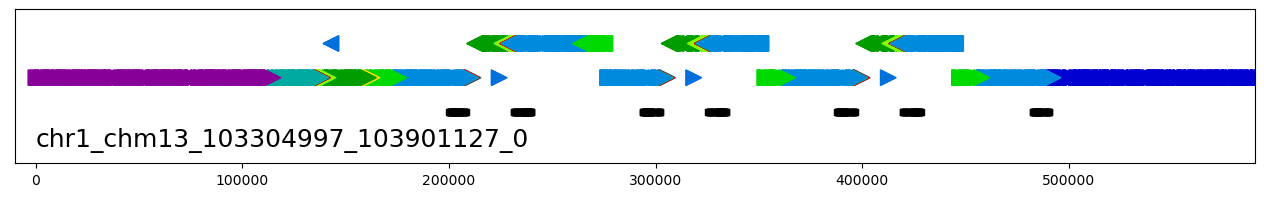

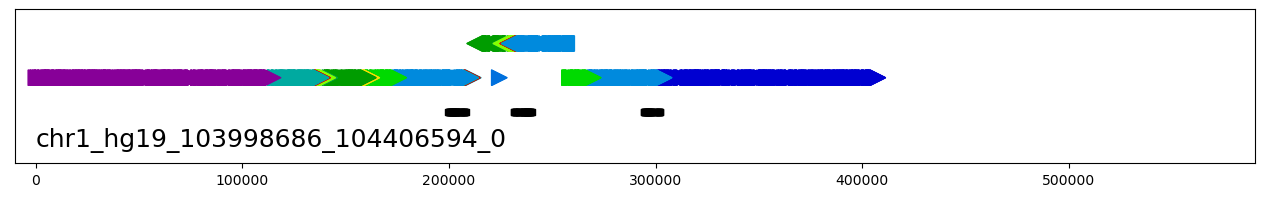

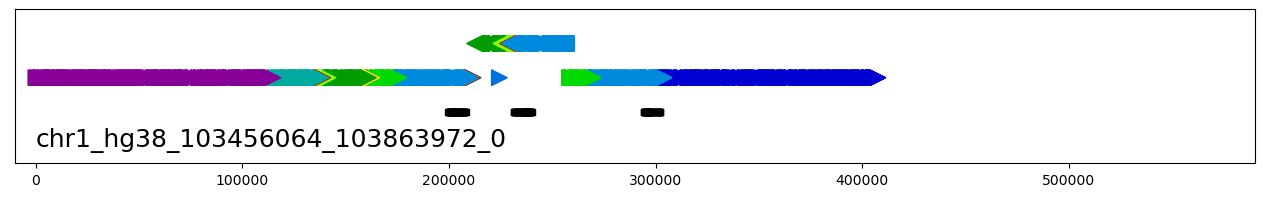

In [37]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])


pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
    matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(4)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.figure(figsize=(16,2))
    plt.scatter(x, y, marker=">", color=c, s=120)
    plt.scatter(rx, ry, marker="<", color=rc, s=120)
    
    #plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color=track0_c, s=20)
    
    track0_x = [_[0] for _ in gene_matches[sid]]
    plt.scatter(track0_x, [-4]*len(track0_x), marker="s", color="black", s=20)
    
    #plt.axis("off")
    plt.ylim(-10,8)
    plt.yticks([])
    plt.xlim(-10000,590000)
    plt.text(0, -8, ctg, fontsize=18)

In [38]:
from matplotlib.colors import to_hex as to_hex

In [39]:
def get_graph3(seq_list, w=48, k=56, r=4, min_span=28):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():

        path.sort()
        v = path[0]

        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            #penwidth =  0.25 + 0.01 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = 0, color="yellow" )
            G.add_edge(w, v, penwidth = 0, color="yellow" )
            #G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
    links = new_sdb.get_smp_adj_list(0)
    #principal_bundles = new_sdb.get_principal_bundles(0, 8);
    principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
    
    lpb = len(principal_bundles)
    color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
    #pseudo-randomize the colors
    idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
    print(idx)
    color_theme = color_theme0[idx]

    node_to_path_id = {}

    for bundle_id, _, bundle in principal_bundles:
        for v in bundle:
            node_to_path_id[tuple(v[:2])] = bundle_id

    
    for sid, path in sid_to_path.items():
        
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            
            if v in node_to_path_id:
                path_id = node_to_path_id[v]
                G.add_node(v, fillcolor=to_hex(color_theme[path_id]), color="white" , style="filled", path_id = path_id)
            else:
                G.add_node(v, color="white", path_id = "-1" )
    return G



In [40]:
w = shmmrspec["w"]
k = shmmrspec["k"]
r = shmmrspec["r"]
min_span = shmmrspec["min_span"]
name="AMY1A_region_segment"
print(w,k,r,min_span)
G = get_graph3(seq_list, w=w, k=k, r=r, min_span=min_span)

48 56 4 28
[ 0  3  6  9 12 15 18 21 24 27  2  5  8 11 14 17 20 23 26  1  4  7 10 13
 16 19 22 25]


In [41]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

28


33 HG002#1#JAHKSE010000012.1_16776806_17183707_1
62 HG002#2#JAHKSD010000021.1_102757493_103165350_0
29 HG00438#1#JAHBCB010000015.1_33474867_33954171_0
14 HG005#1#JAHEPO010000002.1_51519219_51926067_0
64 HG005#2#JAHEPN010000023.1_51542210_51950070_0
2 HG00621#1#JAHBCD010000034.1_2122997_2624098_1
1 HG00621#2#JAHBCC010000031.1_16669999_17077865_0
74 HG00673#2#JAHBBY010000109.1_16675383_17177395_0
36 HG00735#1#JAHBCH010000004.1_101548252_101956125_0
6 HG00741#1#JAHALY010000007.1_18781197_19307680_1
71 HG00741#2#JAHALX010000013.1_51574319_51981226_0
34 HG01071#1#JAHBCF010000053.1_26607100_27108065_1
21 HG01106#1#JAHAMC010000004.1_31121050_31623013_0
22 HG01106#2#JAHAMB010000008.1_19904771_20405763_1
7 HG01109#1#JAHEPA010000099.1_2104245_2511104_1
58 HG01109#2#JAHEOZ010000047.1_16671232_17151375_0
32 HG01123#1#JAGYYZ010000015.1_51528240_51935090_0
50 HG01175#1#JAHAMA010000003.1_33204707_33808232_1
44 HG01175#2#JAHALZ010000031.1_43072077_43478977_1
47 HG01258#1#JAGYYV010000004.1_56955948_574

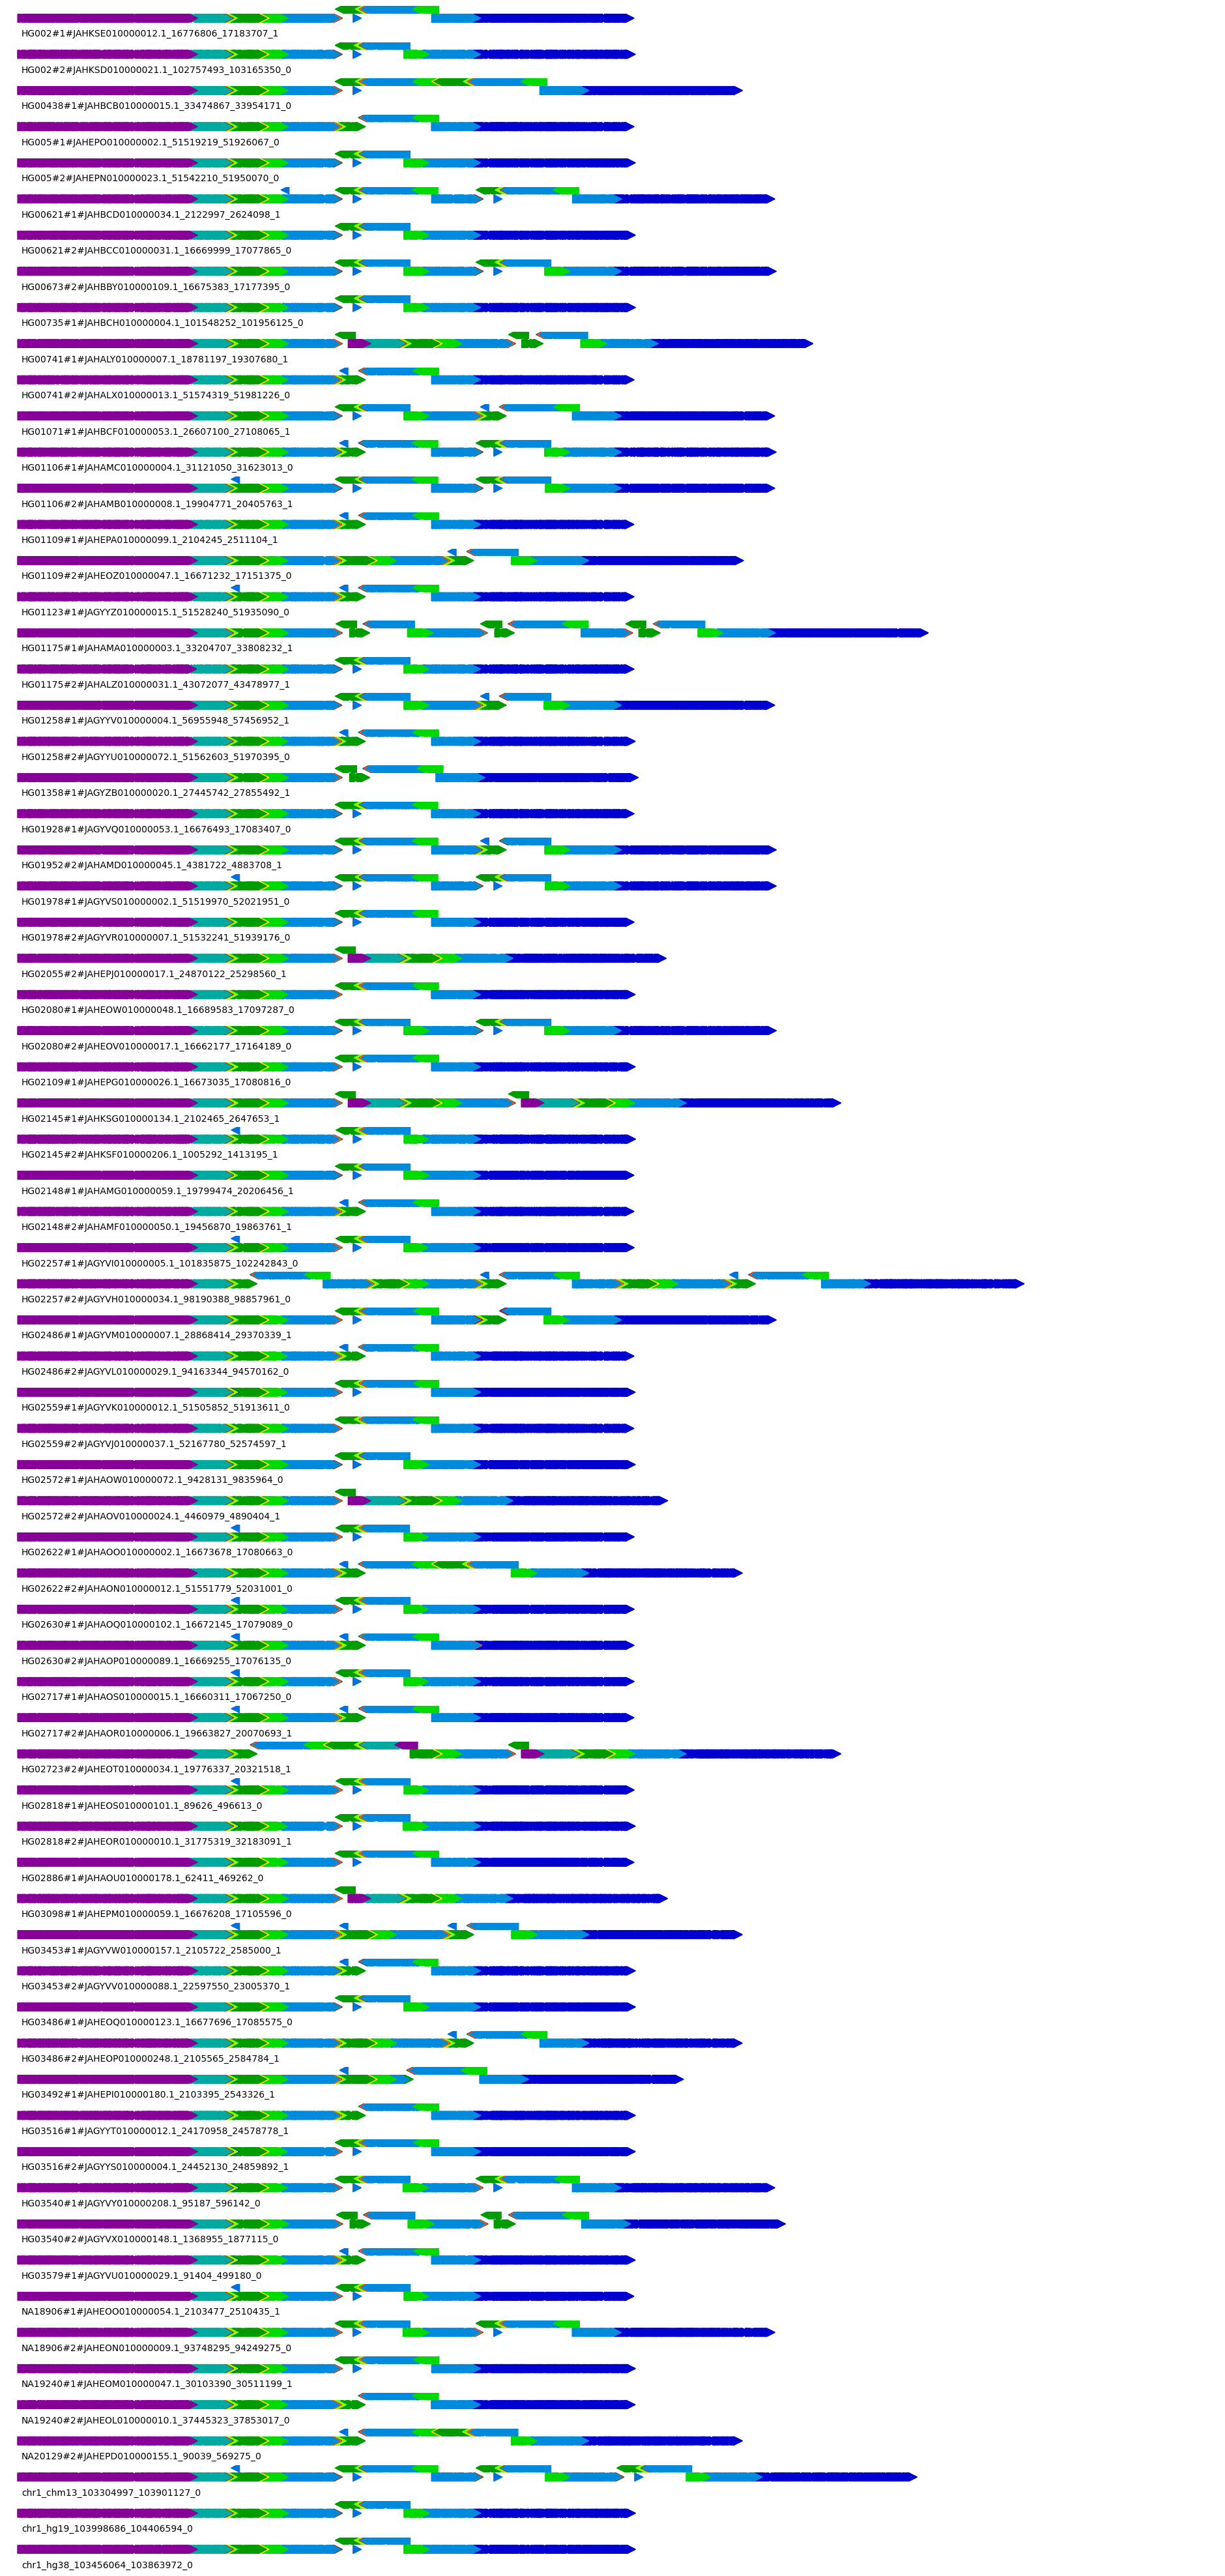

In [42]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
pidx = 1
ctg_labels = []
full_length_sids = []
for sid, data in sinfo:
    
    ctg, _, slen = data
    if slen < 400000:
        continue
    
    ctg_labels.append(ctg)
    full_length_sids.append(sid)
    print(sid, ctg)
    
    smps = sid_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,800000)
    plt.text(0, -12, ctg)

In [43]:
def group_smps_by_principle_bundle_id(smps, len_cutoff=2500, merge_length=5000):
    """ Filter and group SHIMMER pair output from SeqIndexDB.get_principal_bundle_decomposition() 
        by bundle id. This function will filter out small bundle segment with lenght smaller than
        `len_curoff` and merge two bundle with the same id and direction within `merge_length` 

        TODO: This is currently implemented in python, we plan to move this as 
        Rust code in the future.
    
    Parameters
    ----------
    len_cutoff: int
        the length cutoff used for filtering small bundle segement

    merge_length: int
        the length determining if two bundles should be merged 
    
    Returns
    -------
    list
        a list of the lists of SHIMMER pairs tagged with bundle id, direction, position in the bundle  

        each element of the list SHIMMER is a tuple of 
        `((shimmer0, shimmer1, pos0, pos1, direction), 
        bundle_id, direction_to_the_bundle, postion_in bundle)`
    """

    pbid, pdirection = None, None
    all_partitions = []
    for smp, bundle_info in smps:
        if bundle_info is None:
            continue
        d = 0 if smp[4] == bundle_info[1] else 1
        bid = bundle_info[0]
        bpos = bundle_info[2]
        if pbid is None and pdirection is None:
            new_partition = []
            new_partition.append( (smp, bid, d, bpos) )
            pbid = bid
            pdirection = d
            continue
        if bid != pbid or d != pdirection:
            if new_partition[-1][0][3] -  new_partition[0][0][2] > len_cutoff:
                all_partitions.append(new_partition)
                new_partition = []
            else:
                new_partition = []
            pbid = bid
            pdirection = d
            
        new_partition.append( (smp, bid, d, bpos) )
          
    if len(new_partition) != 0 and new_partition[-1][0][3] -  new_partition[0][0][2] > len_cutoff:
        all_partitions.append(new_partition)
        
    partition = all_partitions[0]
    rtn_partitions = []
    for p in all_partitions[1:]:
        
        p_end = partition[-1][0][3]
        p_bid = partition[-1][1]
        p_d = partition[-1][2]
        np_bgn = p[0][0][2]
        np_bid = p[0][1]
        np_d = p[0][2]
        if p_bid == np_bid and p_d == np_d and abs(np_bgn - p_end) < merge_length:
            partition.extend(p)
        else:
            rtn_partitions.append(partition)
            partition = p
    rtn_partitions.append(partition)
        
    return rtn_partitions


In [65]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])


bed_file = open("/results/AMY1A_region_principal_bundles_100_100000.bed","w")
for sid, data in sinfo:
    
    ctg, _, _ = data

    ##print(ctg)
    ctg_items = ctg.split("_")
    ##print(ctg_items[0])
    ctg_bgn = int(ctg_items[-3])
    ctg_end = int(ctg_items[-2])
    ctg_dir = int(ctg_items[-1])
    #assert(ctg_dir==0)

    smps = sid_smps[sid]
    smp_partitions = group_smps_by_principle_bundle_id(smps, 100, 10000)
    mi = 0
    
    ##plt.figure(figsize=(24,3))
    smp_partitions.reverse()
    for p in smp_partitions:
        b = p[0][0][2]
        e = p[-1][0][3] + shmmrspec["k"]
        bid = p[0][1]
        
        direction = p[0][2]
        
        print(ctg, ctg_bgn+b, ctg_bgn+e, 
              "{}:{}:{}:{}".format(bid, direction, p[0][3], p[-1][3]), sep="\t", 
              file=bed_file)
        
        ##color = color_theme[bid]
        ##plt.plot((b,e), (0, 0), "-", linewidth=10, c=color)
        ##plt.text(0, -2 , ctg, fontsize=24)
    ##plt.ylim(-4,5)
    ##plt.xlim(-10000,500000)
bed_file.close()

In [45]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]
        

In [46]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    if len(bundle[2]) == 1: # some small segment used in both directions
        continue
    for v in bundle[2]:
        vertex = tuple(v[:2])
        if vertex in b_vertex_to_position: # some small segment used in both directions
            continue
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

In [47]:
len(full_length_sids), len(ctg_labels), len(sid_smps)

(71, 71, 89)

In [48]:

seq_info = new_sdb.seq_info.copy()

sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])


index_indx_sid = dict([(_[0], _[1]) for _ in enumerate(list(full_length_sids))])
sid_to_index = dict([(_[1], _[0]) for _ in enumerate(list(full_length_sids))])
s_vectors = np.zeros( (len(sid_to_index), len(b_vertex_to_position)))

#ctg_labels = [""]*len(sid_to_smps)


for sid, smps in sid_smps.items():
    if sid not in full_length_sids:
        continue
    ctg, src, _ = seq_info[sid]
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]
        
        if node in b_vertex_to_position:
            idx = sid_to_index[sid]
            s_vectors[idx, b_vertex_to_position[node][0]] += 1
   
    
"""
id_of_interests = []
samples = {}
for sid, smps in sid_to_smps.items():
    if sid in sid_to_index:
        ctg, src, _ = seq_info[sid]
        s = ctg.split("#")[0]
        samples.setdefault(s, [])
        samples[s].append(sid)
        
        if ctg.startswith("chr6_chm13") or ctg.startswith("HG01361"):
            idx = sid_to_index[sid]
            print(sid, ctg, idx, eths[idx])
            
            id_of_interests.append(idx)
""";

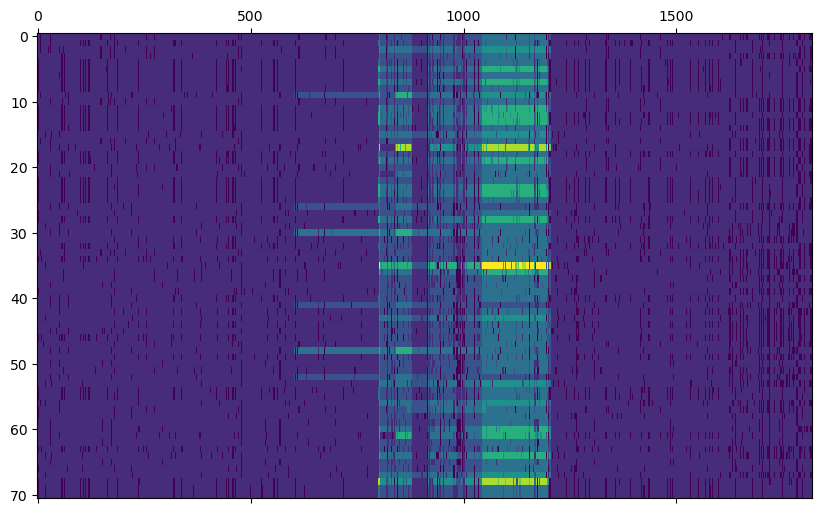

In [49]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(n_components=2)


In [52]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]
        

In [53]:
eths = []
for c in ctg_labels:
    print(c, sample2eth.get(c.split("#")[0], "NA"))
    eths.append(sample2eth.get(c.split("#")[0], "NA"))
    

HG002#1#JAHKSE010000012.1_16776806_17183707_1 AMR
HG002#2#JAHKSD010000021.1_102757493_103165350_0 AMR
HG00438#1#JAHBCB010000015.1_33474867_33954171_0 EAS
HG005#1#JAHEPO010000002.1_51519219_51926067_0 EAS
HG005#2#JAHEPN010000023.1_51542210_51950070_0 EAS
HG00621#1#JAHBCD010000034.1_2122997_2624098_1 EAS
HG00621#2#JAHBCC010000031.1_16669999_17077865_0 EAS
HG00673#2#JAHBBY010000109.1_16675383_17177395_0 EAS
HG00735#1#JAHBCH010000004.1_101548252_101956125_0 AMR
HG00741#1#JAHALY010000007.1_18781197_19307680_1 AMR
HG00741#2#JAHALX010000013.1_51574319_51981226_0 AMR
HG01071#1#JAHBCF010000053.1_26607100_27108065_1 AMR
HG01106#1#JAHAMC010000004.1_31121050_31623013_0 AMR
HG01106#2#JAHAMB010000008.1_19904771_20405763_1 AMR
HG01109#1#JAHEPA010000099.1_2104245_2511104_1 AMR
HG01109#2#JAHEOZ010000047.1_16671232_17151375_0 AMR
HG01123#1#JAGYYZ010000015.1_51528240_51935090_0 AMR
HG01175#1#JAHAMA010000003.1_33204707_33808232_1 AMR
HG01175#2#JAHALZ010000031.1_43072077_43478977_1 AMR
HG01258#1#JAGYYV0100

HG02055#2#JAHEPJ010000017.1_24870122_25298560_1 -18.245554402483275 16.06740670551284 AFR
HG02109#1#JAHEPG010000026.1_16673035_17080816_0 -7.940327016493695 1.3968818555587754 AFR
HG02145#1#JAHKSG010000134.1_2102465_2647653_1 -0.5594079765090713 30.918500358629903 AFR
HG02145#2#JAHKSF010000206.1_1005292_1413195_1 -11.31691189905964 -4.038876336323851 AFR
HG02257#1#JAGYVI010000005.1_101835875_102242843_0 -10.701528367899193 -5.120688551006726 AFR
HG02257#2#JAGYVH010000034.1_98190388_98857961_0 60.59622223698892 11.498894356070664 AFR
HG02486#1#JAGYVM010000007.1_28868414_29370339_1 15.418995763760684 1.308704780253669 AFR
HG02486#2#JAGYVL010000029.1_94163344_94570162_0 -9.51881578526358 0.23327092178394995 AFR
HG02559#1#JAGYVK010000012.1_51505852_51913611_0 -9.010763230070573 0.5569650076387547 AFR
HG02559#2#JAGYVJ010000037.1_52167780_52574597_1 -8.451190720911109 1.4088758311829657 AFR
HG02572#1#JAHAOW010000072.1_9428131_9835964_0 -8.365330974178534 -7.48281975933415 AFR
HG02572#2#JAHAO

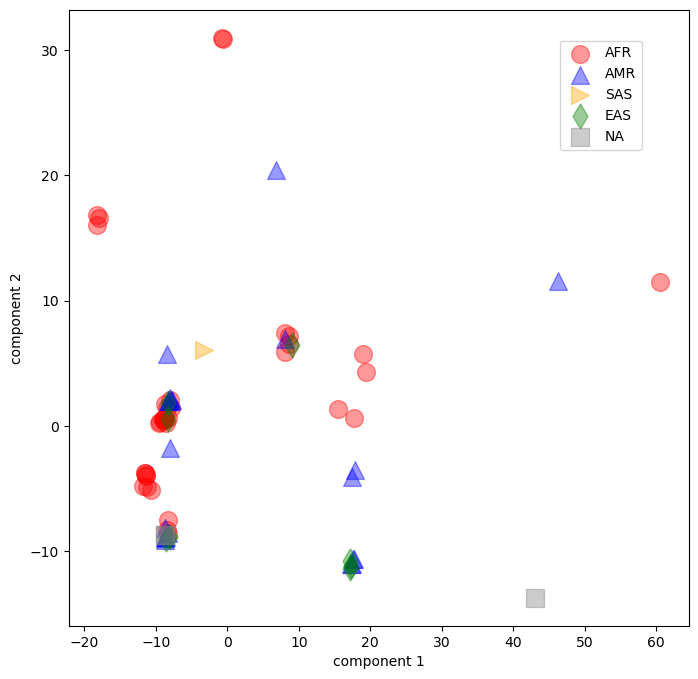

In [54]:
pca = PCA(n_components=2)
comp = pca.fit_transform(s_vectors)

[x, y] = zip( *[ (_[0], _[1]) for _ in comp ] )
c_map = {"AFR":"red", "AMR": "blue", "SAS": "orange", "EAS":"green", "NA":"gray" }
m_map = {"AFR":"o", "AMR": "^", "SAS": ">", "EAS":"d", "NA":"s" }
colors = []

ax=plt.figure(figsize=(8,8))
#xx = np.array(x)
#yy = np.array(y)
#plt.plot(xx[id_of_interests], yy[id_of_interests], "x", markersize=20) 

seq_info = new_sdb.seq_info.copy()


for eth, color in c_map.items():
    xx = []
    yy = []
    for i in range(len(x)):
        
        if eths[i] != eth:
            continue
        print(seq_info[index_indx_sid[i]][0], x[i], y[i], eths[i])
        
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx, yy, alpha=0.4, marker=m_map[eth], c=color, s=164, label=eth)

"""
xx = np.array(x)
yy = np.array(y)

for s in samples:
    if len(samples[s]) == 2:
        sid0, sid1 = samples[s]
        idx0 = sid_to_index[sid0]
        idx1 = sid_to_index[sid1]
        e = eths[idx0]
        c = c_map[e]
        plt.plot((xx[idx0], xx[idx1]), (yy[idx0], yy[idx1]), alpha=0.2, color=c)
 """   
ax.legend(bbox_to_anchor=(0.850, 0.85), loc="upper right")

plt.xlabel("component 1")
plt.ylabel("component 2")
pca_x = np.array(x[:])
pca_y = np.array(y[:])

In [55]:
y_orders = sorted(list([(_[1], _[0]) for _ in enumerate(pca_y)]))

group1 -8.77115639844582 -9.128403823204527 HG01175#2#JAHALZ010000031.1_43072077_43478977_1 AMR
group1 -8.548209625731605 -9.000891222265302 HG005#2#JAHEPN010000023.1_51542210_51950070_0 EAS
group1 -8.704747123651583 -8.960774984229113 HG00735#1#JAHBCH010000004.1_101548252_101956125_0 AMR
group1 -7.988385799618565 -8.909587198212048 HG00621#2#JAHBCC010000031.1_16669999_17077865_0 EAS
group1 -8.700719434226727 -8.852079804906625 HG01978#2#JAGYVR010000007.1_51532241_51939176_0 AMR
group1 -8.609960481193049 -8.847902337720688 HG02148#1#JAHAMG010000059.1_19799474_20206456_1 AMR
group1 -8.718049006277681 -8.748108903490857 chr1_hg19_103998686_104406594_0 NA
group1 -8.718049006277681 -8.748108903490857 chr1_hg38_103456064_103863972_0 NA
group1 -8.338508200191967 -8.616173236804393 HG03486#1#JAHEOQ010000123.1_16677696_17085575_0 AFR
group1 -8.24324100631527 -8.55449297285397 HG01928#1#JAGYVQ010000053.1_16676493_17083407_0 AMR
group1 -8.438375446421176 -8.35411617766445 HG03453#2#JAGYVV0100000

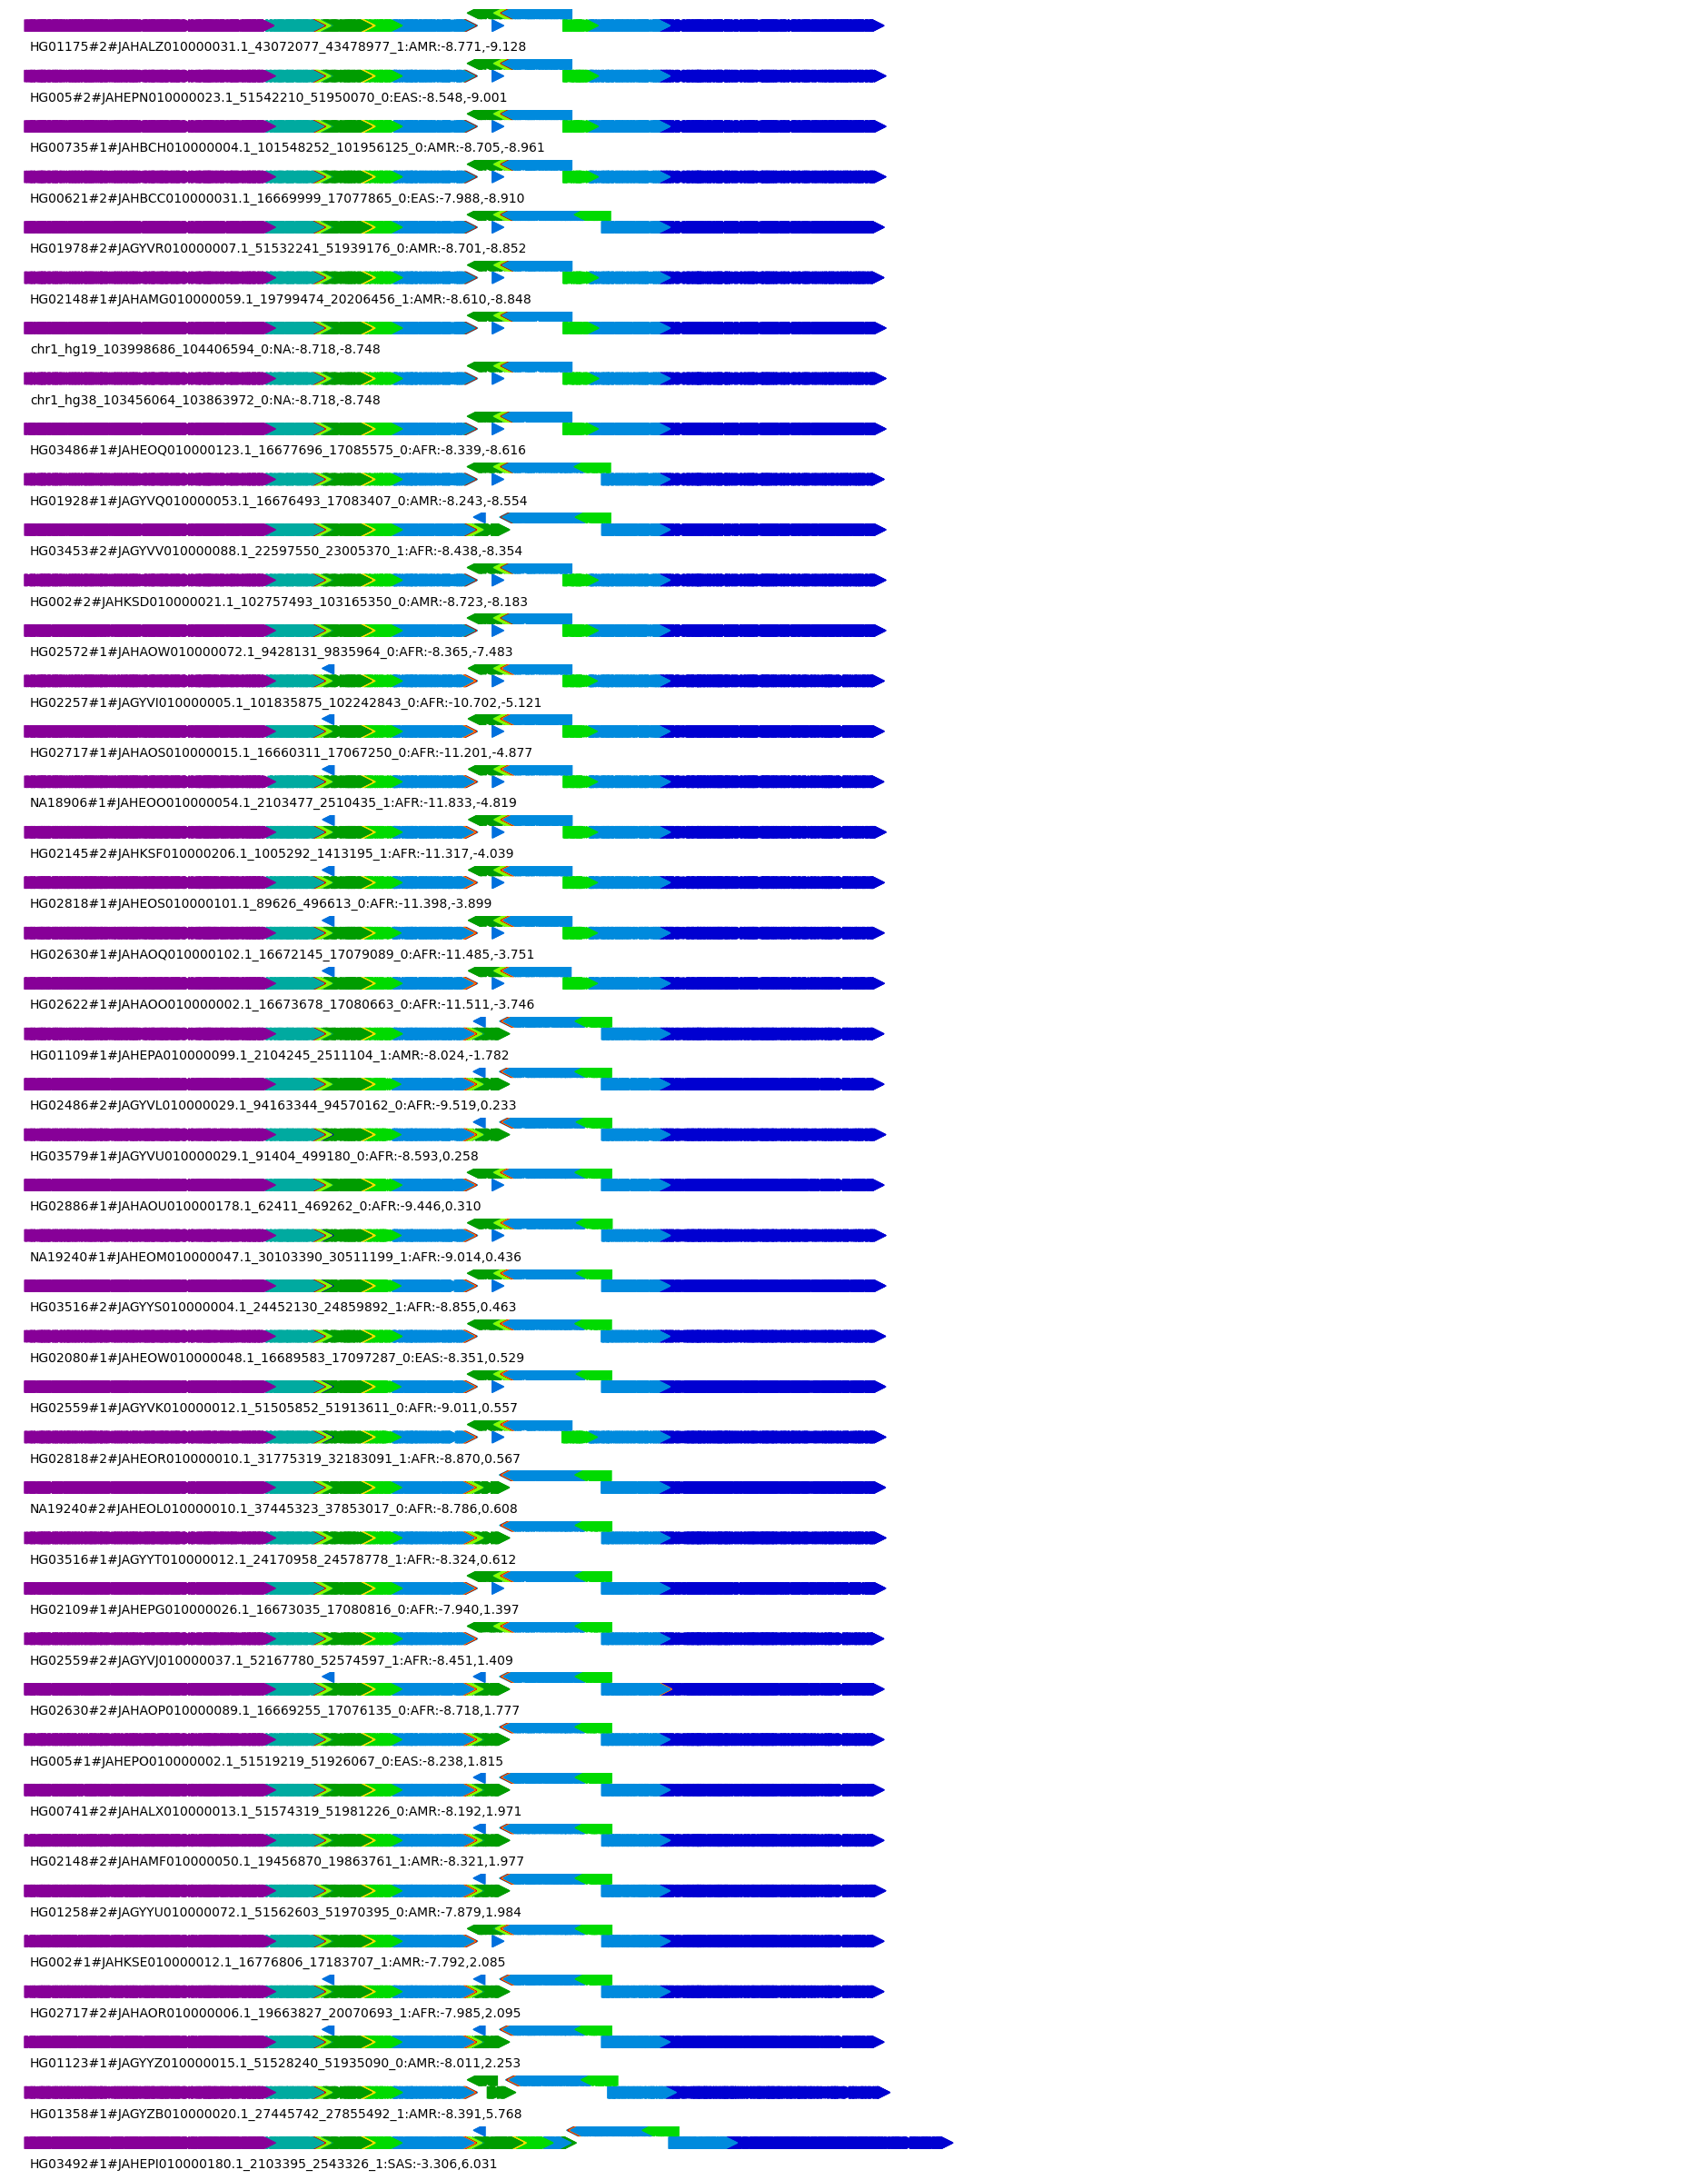

In [56]:
fig = plt.figure(figsize=(24,64))
pidx = 1

for y, idx in y_orders:
    x = pca_x[idx]
    if x > 0:
        continue
    if y > 16:
        continue
    
    sid = index_indx_sid[idx]
    ctg, _, slen = seq_info[sid]
    print("group1",x,y,ctg,eths[idx])
    label = ctg+":"+eths[idx]+":{:0.3f},{:0.3f}".format(x,y)
    if slen < 400000:
        continue
    
    ctg_labels.append(ctg)
    full_length_sids.append(sid)
    #print(sid, ctg)
    
    smps = sid_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000, 800000)
    plt.text(0, -12, label)

group2 -18.245554402483275 16.06740670551284 HG02055#2#JAHEPJ010000017.1_24870122_25298560_1 AFR
group2 -17.96945480770573 16.55139447664872 HG02572#2#JAHAOV010000024.1_4460979_4890404_1 AFR
group2 -18.259140424249175 16.793917067670147 HG03098#1#JAHEPM010000059.1_16676208_17105596_0 AFR
group2 6.8720980672809615 20.446151977663046 HG00741#1#JAHALY010000007.1_18781197_19307680_1 AMR
group2 -0.5594079765090713 30.918500358629903 HG02145#1#JAHKSG010000134.1_2102465_2647653_1 AFR
group2 -0.6833825460833582 30.98231566806138 HG02723#2#JAHEOT010000034.1_19776337_20321518_1 AFR


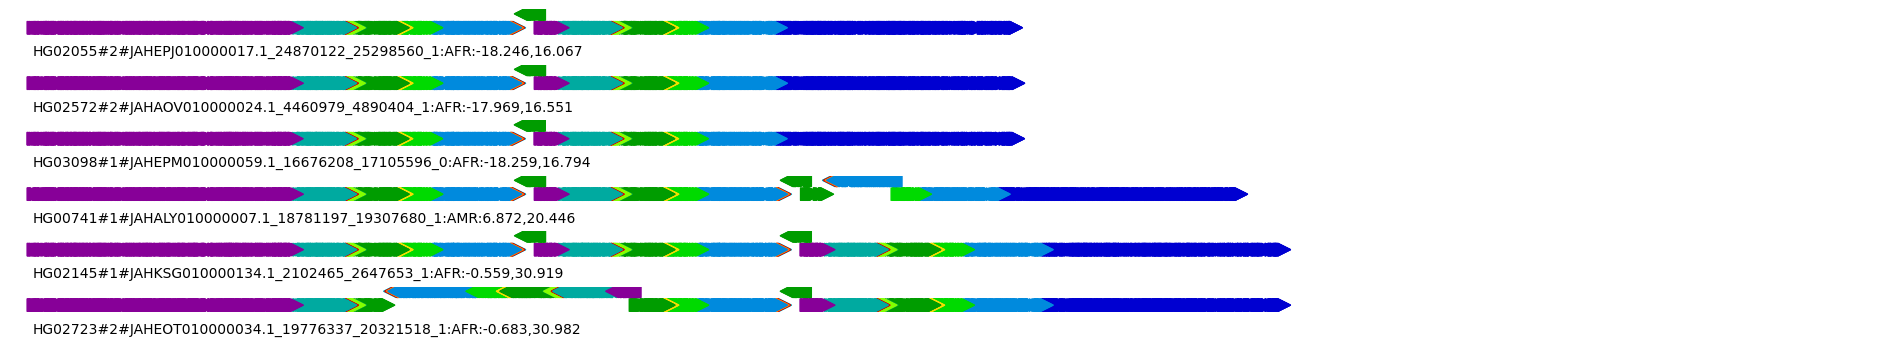

In [57]:
fig = plt.figure(figsize=(24,64))
pidx = 1

for y, idx in y_orders:
    x = pca_x[idx]
    #if x > 0:
    #    continue
    if y < 16:
        continue
    
    sid = index_indx_sid[idx]
    ctg, _, slen = seq_info[sid]
    print("group2", x,y,ctg,eths[idx])
    label = ctg+":"+eths[idx]+":{:0.3f},{:0.3f}".format(x,y)
    if slen < 400000:
        continue
    
    ctg_labels.append(ctg)
    full_length_sids.append(sid)
    #print(sid, ctg)
    
    smps = sid_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000, 800000)
    plt.text(0, -12, label)

group3 17.214350436248527 -11.388027955475211 HG02080#2#JAHEOV010000017.1_16662177_17164189_0 EAS
group3 17.333767346769218 -11.168515782429267 HG00673#2#JAHBBY010000109.1_16675383_17177395_0 EAS
group3 17.297034759021525 -11.039420713283521 HG01106#1#JAHAMC010000004.1_31121050_31623013_0 AMR
group3 17.415412230826995 -11.007380398112293 HG01978#1#JAGYVS010000002.1_51519970_52021951_0 AMR
group3 17.0904413268215 -10.756254960597404 HG00621#1#JAHBCD010000034.1_2122997_2624098_1 EAS
group3 17.60994307705007 -10.64278559725874 HG01106#2#JAHAMB010000008.1_19904771_20405763_1 AMR
group3 17.784930366157216 -10.607458101453883 HG01952#2#JAHAMD010000045.1_4381722_4883708_1 AMR
group3 17.495075690711115 -4.0678221620159265 HG01258#1#JAGYYV010000004.1_56955948_57456952_1 AMR
group3 17.9165878263102 -3.5290502985167804 HG01071#1#JAHBCF010000053.1_26607100_27108065_1 AMR
group3 17.678204347948324 0.6560760220228845 HG03540#1#JAGYVY010000208.1_95187_596142_0 AFR
group3 15.418995763760684 1.30870478

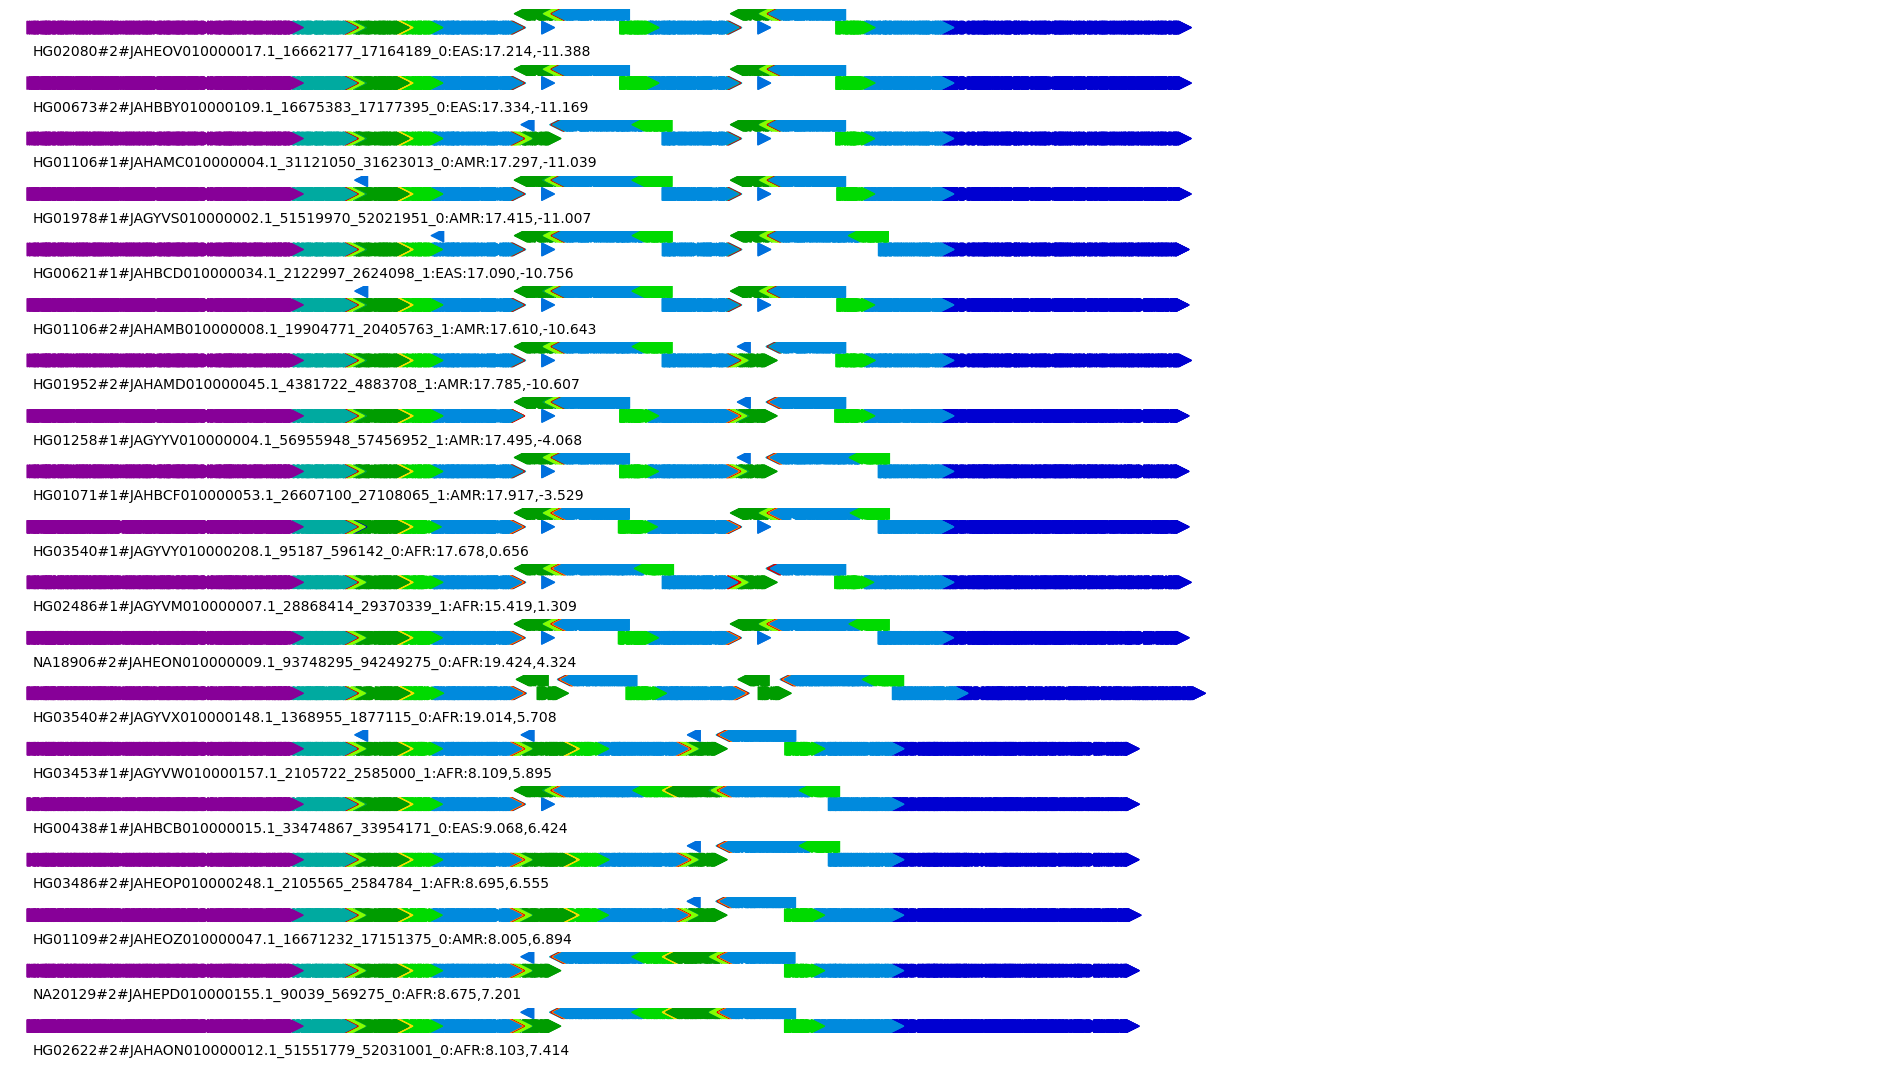

In [58]:
fig = plt.figure(figsize=(24,64))
pidx = 1

for y, idx in y_orders:
    x = pca_x[idx]
    if x <= 0 or x > 30:
        continue
    if y > 16:
        continue
    sid = index_indx_sid[idx]
    ctg, _, slen = seq_info[sid]
    print("group3", x,y,ctg,eths[idx])
    label = ctg+":"+eths[idx]+":{:0.3f},{:0.3f}".format(x,y)
    if slen < 400000:
        continue
    
    ctg_labels.append(ctg)
    full_length_sids.append(sid)
    #print(sid, ctg)
    
    smps = sid_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,800000)
    plt.text(0, -12, label)

group4 42.989398825707795 -13.722873870540973 chr1_chm13_103304997_103901127_0 NA
group4 60.59622223698892 11.498894356070664 HG02257#2#JAGYVH010000034.1_98190388_98857961_0 AFR
group4 46.24306173359432 11.576013560011575 HG01175#1#JAHAMA010000003.1_33204707_33808232_1 AMR


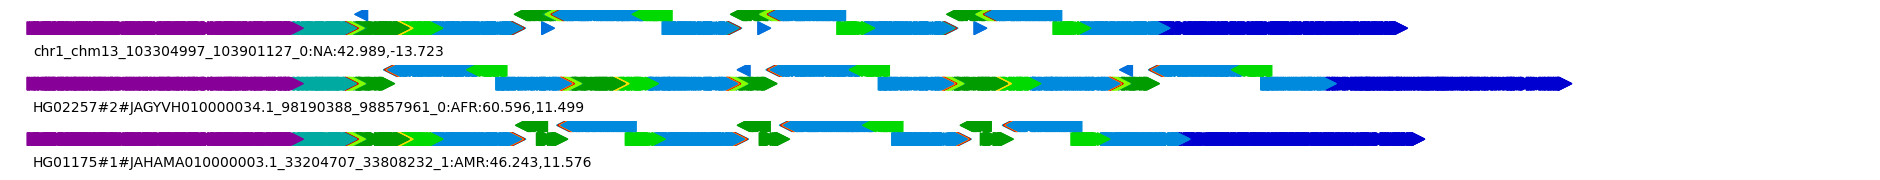

In [59]:
fig = plt.figure(figsize=(24,64))
pidx = 1

for y, idx in y_orders:
    x = pca_x[idx]
    if x <= 30:
        continue
    sid = index_indx_sid[idx]
    ctg, _, slen = seq_info[sid]
    print("group4", x,y,ctg,eths[idx])
    label = ctg+":"+eths[idx]+":{:0.3f},{:0.3f}".format(x,y)
    if slen < 400000:
        continue
    
    ctg_labels.append(ctg)
    full_length_sids.append(sid)
    #print(sid, ctg)
    
    smps = sid_smps[sid]
    
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(-10000,800000)
    plt.text(0, -12, label)

In [60]:
!ls /wd/results/AMY1A_region_principal_bundles.bed

/wd/results/AMY1A_region_principal_bundles.bed


In [61]:
ctg_to_bundles = {}
with open("/results/AMY1A_region_principal_bundles.bed") as f:
    for r in f:
        #print(r)
        r = r.strip().split()
        ctg_to_bundles.setdefault(r[0], [])
        ctg_to_bundles[r[0]].append("{}.{}".format(*r[3].split(":")[0:2]))
    

In [62]:
bundles_to_ctgs = {}
for ctg, bundles in  ctg_to_bundles.items():
    bundles = tuple(bundles)
    bundles_to_ctgs.setdefault(bundles,[])
    bundles_to_ctgs[bundles].append(ctg)


In [63]:
for bundles, ctgs in bundles_to_ctgs.items():
    for ctg in ctgs:
        print("-".join(bundles), ctg)
    print()
        

1.0-2.0-5.1-2.1-4.1-2.0-5.0-4.0-3.0-0.0 HG002#1#JAHKSE010000012.1_16776806_17183707_1

1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG002#2#JAHKSD010000021.1_102757493_103165350_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG005#2#JAHEPN010000023.1_51542210_51950070_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG00621#2#JAHBCC010000031.1_16669999_17077865_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG00735#1#JAHBCH010000004.1_101548252_101956125_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG01175#2#JAHALZ010000031.1_43072077_43478977_1
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG02148#1#JAHAMG010000059.1_19799474_20206456_1
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG02572#1#JAHAOW010000072.1_9428131_9835964_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 HG03486#1#JAHEOQ010000123.1_16677696_17085575_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 chr1_hg19_103998686_104406594_0
1.0-2.0-5.0-2.1-6.1-4.1-2.0-5.0-4.0-3.0-0.0 chr1_hg38_103456064_103863972_0

1.0-2.0-5.1-2.1-4.1-5.1-2.